# 0. Importing Packages

In [3]:
%matplotlib notebook

import time
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
import copy
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel
from scipy.special import erf
from scipy.stats import sigmaclip
from scipy.optimize import minimize
import emcee
import pandas as pd
import warnings
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec 
from scipy.stats import truncnorm
from scipy.stats import skew
from scipy.stats import kurtosis
import tqdm
import init_cfg as ic

# 1. Loading IFU Data

In [4]:
# ----- Basic parameters ----- #
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
redshift = ic.redshift
dist_lum = cosmo.luminosity_distance(redshift).value*1.0e+6    # pc

wav_NII_6548 = 6549.86    # Angstrom (SDSS)
wav_NII_6584 = 6585.27    # Angstrom (SDSS)
wav_Ha = 6564.61    # Angstrom (SDSS)
wav_SII_6717 = 6718.29    # Angstrom (SDSS)
wav_SII_6731 = 6732.67    # Angstrom (SDSS)
wav_OII_3727 = 3727.092    # Angstrom (SDSS)
wav_OII_3729 = 3729.875    # Angstrom (SDSS)
wav_OIII_4959 = 4960.295    # Angstrom (SDSS)
wav_OIII_5007 = 5008.240    # Angstrom (SDSS)
c = 2.99792e+5    # km/s

# ----- Loading Voronoi binned data ----- #
dir_vbin = 'vorbin/'
vb = np.load(dir_vbin+'vorbin_array.npz')
# wav, sci, var, cont
wav_obs = vb['wav']
wav_res = wav_obs / (1.0+redshift)
binned_spectrum = vb['sci']
binned_variance = vb['var']
binned_continuum = vb['cont']
data_vbin = fits.getdata(dir_vbin+'vbin.fits').astype('int')
nbin = binned_spectrum.shape[1]

In [5]:
binned_spectrum.shape

(4591, 431)

In [6]:
data0 = binned_spectrum - binned_continuum
vari0 = binned_variance
cont0 = binned_continuum

dat = data0 * (1.0+redshift)
var = vari0 * (1.0+redshift)**2.0
cont = cont0 * (1.0+redshift)

# Reading the spectral resolution fitting results
par, e_par = np.loadtxt('relation_wav_R.txt').T

In [7]:
print(np.unique(data_vbin, return_counts=True))
binNum, binNpix = np.unique(data_vbin, return_counts=True)
print(0.1*np.sum((binNpix == 1)))
print(0.1*np.sum((binNpix <= 4)))

(array([-99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

## 1.1. Retrieving maximum spectrum

In [8]:
wavcut = fits.getdata("diagram/wavcut_Halpha+NII.fits")
yInd, xInd = np.unravel_index(np.argmax(wavcut), wavcut.shape)
# yInd2, xInd2 = 30, 38    # non-contaminated region
n_bin = data_vbin[yInd, xInd]
print("Maximum intensity bin")
print(f"Bin {n_bin:d}: (x, y) = ({xInd:d}, {yInd:d})")

maximum_spectrum = dat[:, n_bin]
maximum_variance = var[:, n_bin]
maximum_continuum = cont[:, n_bin]

Maximum intensity bin
Bin 0: (x, y) = (32, 29)


## 1.2. Retrieving integrated spectrum with the bin's order

In [9]:
n_integrate = 16
integrated_spectrum = np.sum(dat[:, :n_integrate], axis=1)
integrated_variance = np.sum(var[:, :n_integrate], axis=1)
integrated_continuum = np.sum(cont[:, :n_integrate], axis=1)

## 1.3. Retrieving integrated spectrum within a circle

In [10]:
fin_cb = 'bfcube_3D.fits'

d_sci, h_sci = fits.getdata(fin_cb, ext=1, header=True)
d_var, h_var = fits.getdata(fin_cb, ext=2, header=True)

d_sci[:, 0, :] = 0.
d_sci[:, :, 0] = 0.
d_sci[:, -1, :] = 0.
d_sci[:, :, -1] = 0.

d_sci2 = d_sci * (1+redshift)
d_var2 = d_var * (1+redshift)**2

In [11]:
from photutils.aperture import CircularAperture as CAp
rad = 4
ap = CAp((xInd, yInd), r=rad)
ap_msk = ap.to_mask(method='exact')
msk = ap_msk.to_image((d_sci.shape[1], d_sci.shape[2]))
print(f"Area: {np.sum(msk):.4f} = {np.pi*rad**2:.4f}? ", np.sum(msk) == np.pi*rad**2)

circular_spectrum = np.sum(d_sci2*msk, axis=(1, 2))
circular_variance = np.sum(d_var2*msk, axis=(1, 2))
print(circular_spectrum.shape)

Area: 50.2655 = 50.2655?  True
(4591,)


<IPython.core.display.Javascript object>


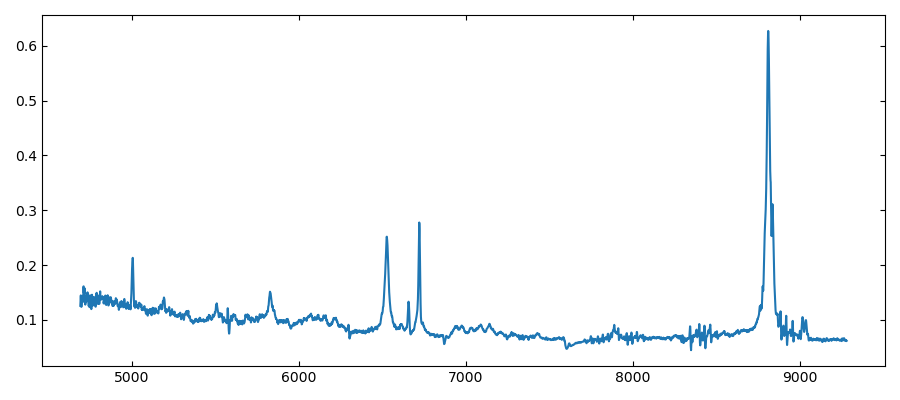

In [12]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_obs, circular_spectrum)
plt.tight_layout()

### 1.3.1. Continuum subtraction for the circular spectrum

<IPython.core.display.Javascript object>


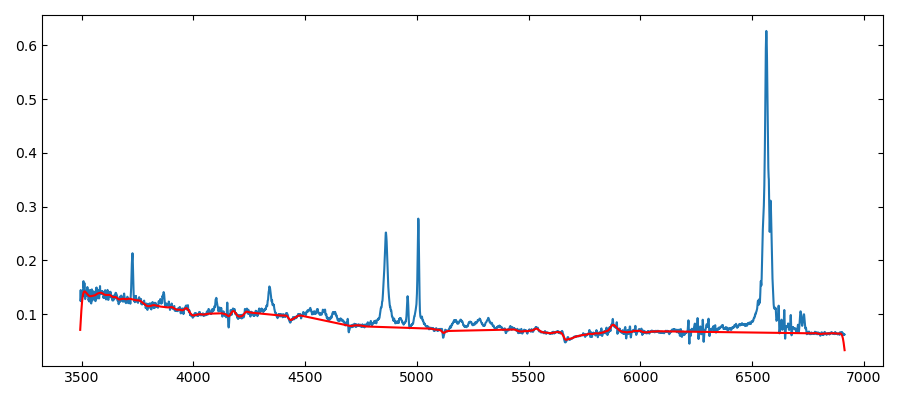

In [13]:
# ----- Continuum fitting ----- #
cont_width = 5  # AA
kernel_width = 10  # AA
sig1, sig2 = 3.0, 4.0  # For sigma clipping

# Wavelength masking range (copied from contfit_init.ipynb)
wav_msk = np.array([[4975, 5025],  # [OII]
                    [5150, 5225],   # [NeIII]
                    [5450, 5550],   # H delta
                    [5700, 5900],   # H gamma
                    [6000, 6320],   # noisy? region
                    [6400, 6800],   # H beta + [OIII]4959/5007
                    [6900, 7300],   # noisy? region
                    [8150, 9075]])   # [NII] + H alpha + [SII]6717/31

# Interpolation
spec_int = copy.deepcopy(circular_spectrum)
for j in np.arange(wav_msk.shape[0]):
    spx_l = np.abs(wav_obs - wav_msk[j,0]).argmin()
    spx_r = np.abs(wav_obs - wav_msk[j,1]).argmin()

    c_l, lo_l, up_l = sigmaclip(spec_int[spx_l-round(cont_width/ic.wav_intv):spx_l], sig1, sig1)  # 20 AA
    c_r, lo_r, up_r = sigmaclip(spec_int[spx_r+1:spx_r+1+round(cont_width/ic.wav_intv)], sig1, sig1)  # 20 AA

    cont_l = c_l.mean()
    cont_r = c_r.mean()

#     spec_int[spx_l:spx_r+1] = 0.5*(cont_l + cont_r)
    spec_int[spx_l:spx_r+1] = cont_l + \
    ((cont_r-cont_l)/(wav_obs[spx_r]-wav_obs[spx_l]))*(wav_obs[spx_l:spx_r+1]-wav_obs[spx_l])

# Sigma clipping
clipped, lower, upper = sigmaclip(spec_int, sig2, sig2)
spec_int_clipped = copy.deepcopy(spec_int)
spec_int_clipped[spec_int < lower] = clipped.mean()
spec_int_clipped[spec_int > upper] = clipped.mean()

# Smoothing spectra
g = Gaussian1DKernel(stddev = round(kernel_width/ic.wav_intv))  # 10 AA
spec_filt = convolve(spec_int_clipped, g)  # spec_int OR spec_int_clipped

# Plotting & saving results
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_res, circular_spectrum)
ax.plot(wav_res, spec_filt, '-', color='red')
plt.tight_layout()
plt.savefig("subcircular_0.png", dpi=300)

subcircular_spectrum = circular_spectrum - spec_filt
subcircular_variance = circular_variance
subcircular_continuum = spec_filt

In [14]:
mode = "subcircular"
# "maximum" OR "integrated" OR "subcircular"

exec("fit_spectrum = copy.deepcopy("+mode+"_spectrum)")
exec("fit_variance = copy.deepcopy("+mode+"_variance)")
exec("fit_continuum = copy.deepcopy("+mode+"_continuum)")

In [15]:
# df = pd.DataFrame(data = {'wav_res':wav_res,
#                           'flux_density':circular_spectrum,
#                           'variance':subcircular_variance,
#                           'continuum':subcircular_continuum})
# df.to_csv("GMOS_data.csv")

<IPython.core.display.Javascript object>


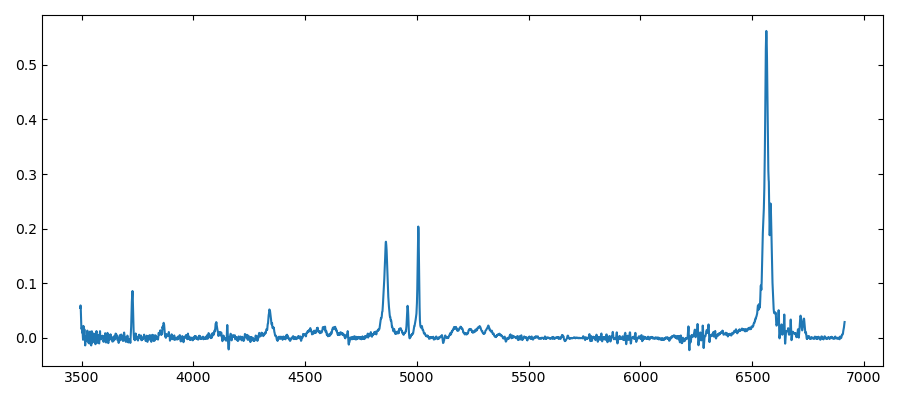

In [16]:
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(wav_res, fit_spectrum)
plt.tight_layout()

# 2. Basic Setting of Line Fitting

In [17]:
np.random.seed(0)
maxfev = 2000

In [18]:
from scipy.optimize import curve_fit
from scipy.special import erf

def gauss_cdf_scale(x, mu, sigma, flux_scale):
    dx = x[1] - x[0]
    v1 = erf((x-mu+0.5*dx)/(np.sqrt(2.0)*sigma))
    v2 = erf((x-mu-0.5*dx)/(np.sqrt(2.0)*sigma))
    return flux_scale*(v1-v2)/(2.0*dx)

def multin_gauss_cdf_scale(x, *pars, n=2, n_broad=0):
    g_i = 0
    n_narrow = n - n_broad
    for i in np.arange(n):
        if (i < n_narrow):
            g_i += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
        else:
            i_b = i-(n_narrow)
            npn = 2*n_narrow
            g_i += gauss_cdf_scale(x, pars[npn+3*i_b+1], pars[npn+3*i_b+2], pars[npn+3*i_b+3])
    return g_i

In [49]:
def line_par(line_numbers, broad_component = False):

    if (line_numbers == 0):
        nlines, nbroad = 1, 0  # 2, 0
        line_names = ['OII3727']#, 'OII3729']
        line_wav = [3727.092]#, 3729.875]
        line_sigma = [3.0]
        wav_fit = [3720.0, 3740.0]
    
    if (line_numbers == 1):
        if broad_component:
            nlines, nbroad = 2, 1
            line_names = ['Hbeta', 'Broad1_1']
            line_wav = [4862.68, 4862.68]
            line_sigma = [3.0, 20.0]
            wav_fit = [4810.0, 4910.0]
        else:
            nlines, nbroad = 1, 0
            line_names = ['Hbeta']
            line_wav = [4862.68]
            line_sigma = [3.0]
            wav_fit = [4855.0, 4870.0]

    if (line_numbers == 2):
        if broad_component:
            nlines, nbroad = 3, 1
            line_names = ['OIII4959', 'OIII5007', 'Broad2_1']
            line_wav = [4960.295, 5008.240, 5008.240]
            line_sigma = [3.0, 20.0]
            wav_fit = [4940.0, 5040.0]
        else:    
            nlines, nbroad = 2, 0
            line_names = ['OIII4959', 'OIII5007']
            line_wav = [4960.295, 5008.240]
            line_sigma = [3.0]
            wav_fit = [4950.0, 5015.0]        

    if (line_numbers == 3):
        if broad_component:
            nlines, nbroad = 4, 1
            line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad3_1']
            line_wav = [6549.86, 6564.61, 6585.27, 6564.61]
            line_sigma = [3.0, 30.0]
            wav_fit = [6500.0, 6625.0]
        else:
            nlines, nbroad = 3, 0
            line_names = ['NII6548', 'Halpha', 'NII6584']
            line_wav = [6549.86, 6564.61, 6585.27]
            line_sigma = [3.0]
            wav_fit = [6540.0, 6595.0]

    if (line_numbers == 4):
        nlines, nbroad = 2, 0
        line_names = ['SII6717', 'SII6731']
        line_wav = [6718.29, 6732.67]
        line_sigma = [3.0]
        wav_fit = [6710.0, 6740.0]

    if (line_numbers == 5):
        nlines, nbroad = 1, 0
        line_names = ['OI6300']
        line_wav = [6302.046]
        line_sigma = [3.0]
        wav_fit = [6295.0, 6310.0]

    if (line_numbers == 6):
        if broad_component:
            nlines, nbroad = 4, 1
            line_names = ['Hbeta', 'OIII4959', 'OIII5007', 'Broad6_1']
            line_wav = [4862.68, 4960.295, 5008.240, 4862.68]
            line_sigma = [3.0, 10.0]
            wav_fit = [4820.0, 5040.0]
        else:
            nlines, nbroad = 3, 0
            line_names = ['Hbeta', 'OIII4959', 'OIII5007']
            line_wav = [4862.68, 4960.295, 5008.240]
            line_sigma = [3.0]
            wav_fit = [4840.0, 5020.0]
        
    line_model = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nlines, n_broad=nbroad)
    
    return [nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model]

f = open('linefit_integrated.txt','w')
f.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq\n')
f.close()

broad = True
if broad:
    g = open('linefit_integrated_broad.txt','w')
    g.write('# line  mu  e_mu  lsig  e_lsig  vsig  e_vsig  R  e_R  flux  e_flux  rchisq flxsum_scale\n')
    g.close()

# 3. Emission Line Fitting

In [50]:
def line_fit(line_numbers, n_fit=1000, maxfev=2000, write=True, broad_component=False,
             mode='automatic', mask=False, xtot=wav_res, ytot=fit_spectrum, e2_ytot=fit_variance, **kwargs):
    # Line fitting: Monte Carlo simulation of curve_fit    

#     if (mode == 'automatic'):
    lp = line_par(line_numbers, broad_component=broad_component)
    nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = lp        

    if (mode == 'manual'):
        nlines     = kwargs['nlines']
        nbroad     = kwargs['nbroad']
        line_names = kwargs['line_names']
        line_wav   = kwargs['line_wav']
        line_sigma = kwargs['line_sigma']
        wav_fit    = kwargs['wav_fit']
        line_model = kwargs['line_model']
        if mask:
            mask_range = kwargs['mask_range']

    spx_fit = [np.abs(xtot-wav_fit[0]).argmin(),
               np.abs(xtot-wav_fit[1]).argmin()]
    x_bin = xtot[1] - xtot[0]
    x_wav = xtot[spx_fit[0]:spx_fit[1]+1]    
    
    if mask:
        idx_nmsk = []
        for i in np.arange(np.shape(mask_range)[0]):
            if (i == 0):
                idx_nmsk.extend(list(range(0, np.abs(x_wav-mask_range[i][0]).argmin())))
            else:
                idx_nmsk.extend(list(range(np.abs(x_wav-mask_range[i-1][1]).argmin(),
                                np.abs(x_wav-mask_range[i][0]).argmin())))
        idx_nmsk.extend(list(range(np.abs(x_wav-mask_range[-1][1]).argmin(), len(x_wav))))

        x_wav = x_wav[idx_nmsk]
        y_loc = ytot[spx_fit[0]:spx_fit[1]+1][idx_nmsk]
        y_var = e2_ytot[spx_fit[0]:spx_fit[1]+1][idx_nmsk]
    
    else:
        y_loc = ytot[spx_fit[0]:spx_fit[1]+1]
        y_var = e2_ytot[spx_fit[0]:spx_fit[1]+1]

    x_fit = np.log(x_wav)
    flx_scale0 = np.sum(np.abs(y_loc)*x_bin)

    mpopt = []
    for i in tqdm.trange(n_fit):
        y_dat = np.random.normal(y_loc, np.sqrt(y_var))
        outliers = np.abs(y_loc-y_dat) > 3.0*np.sqrt(y_var)
        y_dat[outliers] = y_loc[outliers]
        y_fit = x_wav * y_dat

        param = [line_sigma[0] / line_wav[0]]
        for j in np.arange(nlines):
            if (j < nlines-nbroad):
                param += [np.log(line_wav[j]), flx_scale0 / nlines]
            else:
                param += [np.log(line_wav[j]),
                          line_sigma[j-(nlines-nbroad-1)] / line_wav[j],
                          flx_scale0 / nlines]
                
        popt, pcov = curve_fit(line_model, x_fit, y_fit, param, maxfev=maxfev)
        perr = np.sqrt(np.diag(pcov))
        mpopt.append(popt)

    mpar = np.mean(mpopt, axis=0)
    e_mpar = np.std(mpopt, axis=0)


    # Printing & writing the results
    for i in np.arange(nlines):
        if (i == 0):
            print("----- Narrow components -----")
        if (i == nlines-nbroad):
            print("----- Broad components -----")

        if (i < nlines-nbroad):
            mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
            vsig, e_vsig = c*mpar[0], c*e_mpar[0]
            flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
        else:
            mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
            vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
            flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        

        print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

        print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
        lsig = mu * vsig / c
        e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
        print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

        specR = par[0]+par[1]*mu*(1+redshift)
        e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
        print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

        print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

        spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                    np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
        chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
        dof = len(y_loc) - len(param)
        rchisq = np.sum(chisq) / dof
#         dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
#         rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
        print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
        print("\n")
        
    if write:
        f = open('linefit_integrated.txt','a')
        g = open('linefit_integrated_broad.txt','a')
        for i in np.arange(nlines):
            if (line_names[i][:5] != 'Broad'):
                f.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
                f.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
                f.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
                f.write(f"{specR:.2f}  {e_specR:.2f}  ")
                f.write(f"{flux:.2e}  {e_flux:.2e}  ")
                f.write(f"{rchisq:.2f}\n")
            else:
                g.write(line_names[i]+f"  {mu:.3f}  {e_mu:.3f}  ")
                g.write(f"{lsig:.3f}  {e_lsig:.3f}  ")
                g.write(f"{vsig:.2f}  {e_vsig:.3f}  ")
                g.write(f"{specR:.2f}  {e_specR:.2f}  ")
                g.write(f"{flux:.2e}  {e_flux:.2e}  ")
                g.write(f"{rchisq:.2f}  ")
                g.write(f"{flx_scale0:.2e}\n")
        f.close()
        g.close()


    # Figure
    fig, ax = plt.subplots(figsize=(7,5))
    ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
    ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Flux')
    ax.plot(xtot, ytot, color='C0')
    if (nbroad >= 1):
        for i in np.arange(nlines):
            if (i < nlines-nbroad):
                y_plt = gauss_cdf_scale(xtot, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
                lc, ls = 'C1', '-'
            else:
                y_plt = gauss_cdf_scale(xtot, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
                lc, ls = 'C3', '--'
            ax.plot(xtot, y_plt, color=lc, linestyle=ls, alpha=0.75)                
    ax.plot(xtot, ytot - line_model(np.log(xtot), *mpar) / xtot - 0.7*np.abs(np.max(y_loc)),
            color='C2', alpha=0.75)
    ax.plot(xtot, line_model(np.log(xtot), *mpar) / xtot, color='C6', alpha=0.9)
    plt.tight_layout()
    plt.savefig(f"fit0_line{line_numbers:02d}.png", dpi=300)

    # Saving broad components
    b_var = []
    for i in np.arange(nbroad):
        mpar_b = mpar[2*(nlines-nbroad)+(3*i+1):2*(nlines-nbroad)+(3*i+4)]
        b_var.extend(mpar_b)
    print(b_var)
        
    return [mpar, e_mpar]

## 3.1. ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

100%|██████████| 100/100 [00:01<00:00, 52.12it/s]

----- Narrow components -----
NII6548 mean: 6549.352 +/- 0.085 Angstrom
NII6548 sigma: 272.64 +/- 0.878 km/s
NII6548 sigma: 5.956 +/- 0.019 Angstrom
NII6548 R: 1197.39 +/- 44.72
NII6548 flux: 1.53e+00 +/- 1.97e-02
NII6548 reduced chi-square: 17.47


Halpha mean: 6563.572 +/- 0.023 Angstrom
Halpha sigma: 272.64 +/- 0.878 km/s
Halpha sigma: 5.969 +/- 0.019 Angstrom
Halpha R: 1200.00 +/- 44.78
Halpha flux: 7.04e+00 +/- 3.06e-02
Halpha reduced chi-square: 17.47


NII6584 mean: 6581.537 +/- 0.045 Angstrom
NII6584 sigma: 272.64 +/- 0.878 km/s
NII6584 sigma: 5.985 +/- 0.019 Angstrom
NII6584 R: 1203.30 +/- 44.85
NII6584 flux: 2.38e+00 +/- 1.76e-02
NII6584 reduced chi-square: 17.47


----- Broad components -----
Broad3_1 mean: 6559.982 +/- 0.178 Angstrom
Broad3_1 sigma: 1662.31 +/- 17.006 km/s
Broad3_1 sigma: 36.374 +/- 0.372 Angstrom
Broad3_1 R: 1199.34 +/- 44.76
Broad3_1 flux: 7.13e+00 +/- 4.37e-02
Broad3_1 reduced chi-square: 17.47




<IPython.core.display.Javascript object>


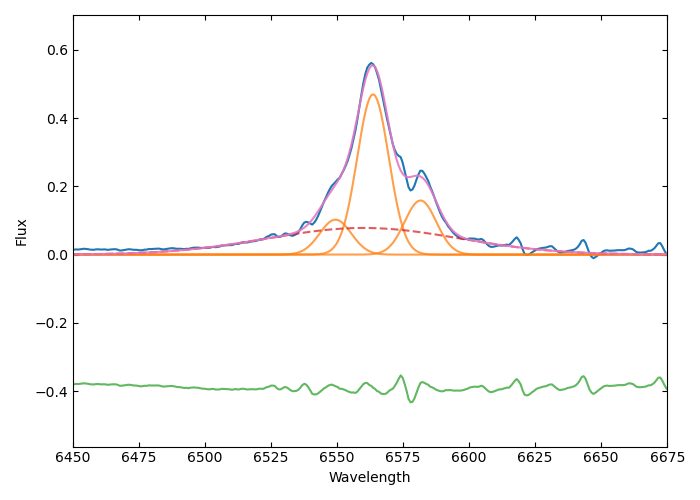

[8.788743179874219, 0.005544873874943416, 7.129928713678249]


[array([9.09432342e-04, 8.78712139e+00, 1.53270504e+00, 8.78929028e+00,
        7.03673424e+00, 8.79202363e+00, 2.38360116e+00, 8.78874318e+00,
        5.54487387e-03, 7.12992871e+00]),
 array([2.93017824e-06, 1.29749102e-05, 1.96833781e-02, 3.47389442e-06,
        3.06213240e-02, 6.83612974e-06, 1.76151285e-02, 2.71210066e-05,
        5.67244058e-05, 4.36696370e-02])]

In [51]:
line_fit(3, n_fit=100, maxfev=2000, write=True, broad_component=True)

100%|██████████| 100/100 [00:01<00:00, 51.94it/s]

----- Narrow components -----
NII6548 mean: 6546.615 +/- 5.407 Angstrom
NII6548 sigma: 271.72 +/- 7.790 km/s
NII6548 sigma: 5.934 +/- 0.170 Angstrom
NII6548 R: 1196.89 +/- 44.71
NII6548 flux: 1.17e+00 +/- 9.46e-01
NII6548 reduced chi-square: 35.07


Halpha mean: 6563.524 +/- 0.091 Angstrom
Halpha sigma: 271.72 +/- 7.790 km/s
Halpha sigma: 5.949 +/- 0.171 Angstrom
Halpha R: 1199.99 +/- 44.78
Halpha flux: 6.84e+00 +/- 7.95e-01
Halpha reduced chi-square: 35.07


NII6584 mean: 6581.646 +/- 0.151 Angstrom
NII6584 sigma: 271.72 +/- 7.790 km/s
NII6584 sigma: 5.965 +/- 0.171 Angstrom
NII6584 R: 1203.31 +/- 44.85
NII6584 flux: 2.29e+00 +/- 4.24e-01
NII6584 reduced chi-square: 35.07


----- Broad components -----
Broad3_1 mean: 6558.829 +/- 0.195 Angstrom
Broad3_1 sigma: 1690.52 +/- 262.927 km/s
Broad3_1 sigma: 36.985 +/- 5.752 Angstrom
Broad3_1 R: 1199.13 +/- 44.76
Broad3_1 flux: 7.89e+00 +/- 1.85e+00
Broad3_1 reduced chi-square: 35.07




<IPython.core.display.Javascript object>


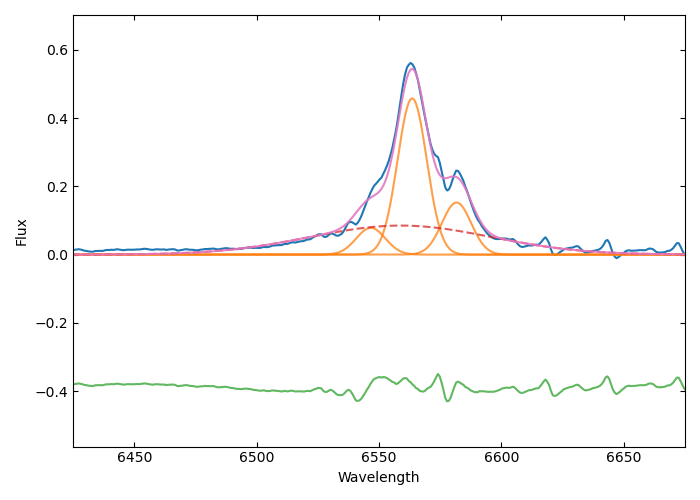

[8.788567423914367, 0.005638978975121629, 7.892475241119032]


In [54]:
nl, nb = 4, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['NII6548', 'Halpha', 'NII6584', 'Broad3_1'],# 'Broad3_2', 'Broad3_2'],
           'line_wav':[6549.86, 6564.61, 6585.27, 6560.0],# 6564.61, 6564.61],
           'line_sigma':[3.0, 35.0], 'wav_fit':[6475.0, 6625.0],#[6450.0, 6625.0],
           'line_model':lm}

s1, e_s1 = line_fit(3, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, xtot=wav_res, ytot=fit_spectrum, e2_ytot=fit_variance, **kw_lpar)
s1_b = s1[2*(nl-nb)+1:]

100%|██████████| 100/100 [00:01<00:00, 61.99it/s]

----- Narrow components -----
NII6548 mean: 6547.771 +/- 0.099 Angstrom
NII6548 sigma: 167.22 +/- 1.849 km/s
NII6548 sigma: 3.652 +/- 0.040 Angstrom
NII6548 R: 1197.10 +/- 44.71
NII6548 flux: 5.15e-01 +/- 2.76e-02
NII6548 reduced chi-square: 10.52


Halpha mean: 6562.462 +/- 0.057 Angstrom
Halpha sigma: 167.22 +/- 1.849 km/s
Halpha sigma: 3.661 +/- 0.040 Angstrom
Halpha R: 1199.79 +/- 44.77
Halpha flux: 1.54e+00 +/- 3.83e-02
Halpha reduced chi-square: 10.52


NII6584 mean: 6583.978 +/- 0.040 Angstrom
NII6584 sigma: 167.22 +/- 1.849 km/s
NII6584 sigma: 3.673 +/- 0.041 Angstrom
NII6584 R: 1203.74 +/- 44.86
NII6584 flux: 1.19e+00 +/- 1.98e-02
NII6584 reduced chi-square: 10.52


----- Broad components -----
Broad3_1 mean: 6564.386 +/- 0.065 Angstrom
Broad3_1 sigma: 414.14 +/- 4.165 km/s
Broad3_1 sigma: 9.068 +/- 0.091 Angstrom
Broad3_1 R: 1200.15 +/- 44.78
Broad3_1 flux: 7.23e+00 +/- 6.49e-02
Broad3_1 reduced chi-square: 10.52




<IPython.core.display.Javascript object>


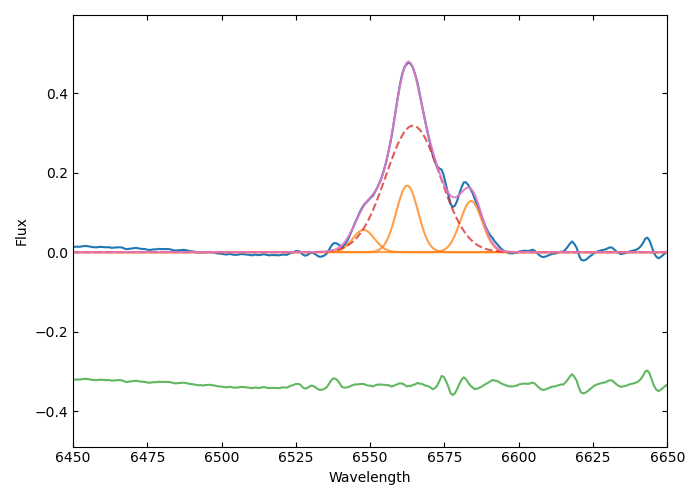

[8.789414236178697, 0.0013814345512230394, 7.23334925729984]


In [55]:
ysub = fit_spectrum - gauss_cdf_scale(wav_res, np.exp(s1_b[0]), s1_b[1]*np.exp(s1_b[0]), s1_b[2])

nl, nb = 4, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['NII6548', 'Halpha', 'NII6584', 'Broad3_1'],# 'Broad3_2', 'Broad3_2'],
           'line_wav':[6549.86, 6564.61, 6585.27, 6564.61],# 6564.61, 6564.61],
           'line_sigma':[3.0, 15.0], 'wav_fit':[6500.0, 6600.0],
           'line_model':lm}

s2, e_s2 = line_fit(3, n_fit=100, maxfev=2000, write=False, broad_component=True,
              mode='manual', mask=False, ytot=ysub, **kw_lpar)
s2_b = s2[2*(nl-nb)+1:]

100%|██████████| 100/100 [00:00<00:00, 223.56it/s]

----- Narrow components -----
NII6548 mean: 6547.850 +/- 0.073 Angstrom
NII6548 sigma: 166.81 +/- 0.945 km/s
NII6548 sigma: 3.643 +/- 0.021 Angstrom
NII6548 R: 1197.11 +/- 44.71
NII6548 flux: 5.13e-01 +/- 7.36e-03
NII6548 reduced chi-square: 9.29


Halpha mean: 6562.458 +/- 0.028 Angstrom
Halpha sigma: 166.81 +/- 0.945 km/s
Halpha sigma: 3.652 +/- 0.021 Angstrom
Halpha R: 1199.79 +/- 44.77
Halpha flux: 1.54e+00 +/- 9.72e-03
Halpha reduced chi-square: 9.29


NII6584 mean: 6583.981 +/- 0.037 Angstrom
NII6584 sigma: 166.81 +/- 0.945 km/s
NII6584 sigma: 3.664 +/- 0.021 Angstrom
NII6584 R: 1203.74 +/- 44.86
NII6584 flux: 1.19e+00 +/- 9.51e-03
NII6584 reduced chi-square: 9.29




<IPython.core.display.Javascript object>


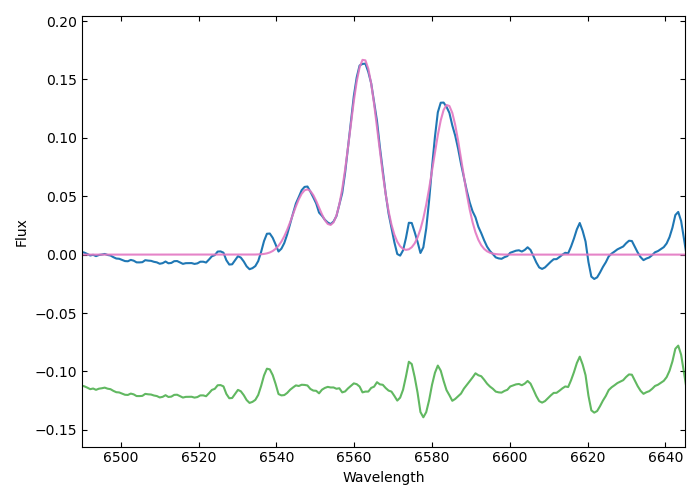

[]


In [56]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(s1_b[0]), s1_b[1]*np.exp(s1_b[0]), s1_b[2]) + \
                       gauss_cdf_scale(wav_res, np.exp(s2_b[0]), s2_b[1]*np.exp(s2_b[0]), s2_b[2]))

nl, nb = 3, 0
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['NII6548', 'Halpha', 'NII6584'],# 'Broad3_2', 'Broad3_2'],
           'line_wav':[6549.86, 6564.61, 6585.27],# 6564.61, 6564.61],
           'line_sigma':[4.0], 'wav_fit':[6540.0, 6595.0],
           'line_model':lm}

s3, e_s3 = line_fit(3, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, ytot=ysub, **kw_lpar)

<IPython.core.display.Javascript object>


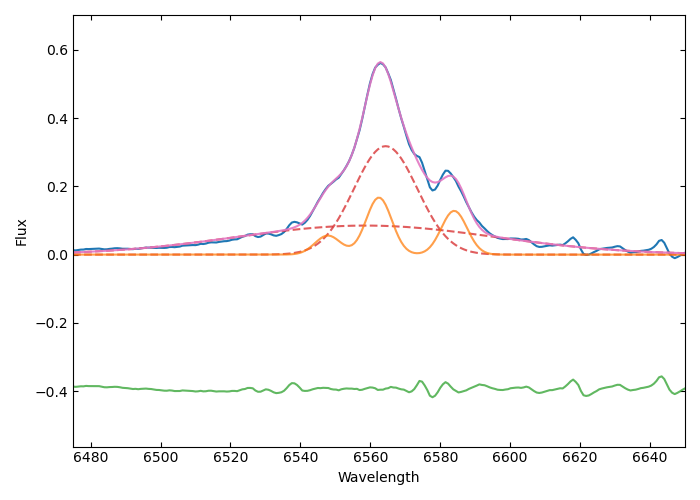

Total reduced chi-square: 13.95


In [57]:
# Combing all the components
npar = s3
bpar = [s1_b, s2_b]
cpar = list(npar) + list(bpar[0]) + list(bpar[1])

lp = line_par(3, broad_component=True)
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = lp
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=5, n_broad=2)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]    
y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
y_mod = lm(np.log(wav_res), *cpar) / wav_res

# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-25.0, wav_fit[1]+25.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum, color='C0')
for i in np.arange(len(bpar)):
    y_plt = gauss_cdf_scale(np.log(wav_res), *bpar[i]) / wav_res
    ax.plot(wav_res, y_plt, color='C3', linestyle='--', alpha=0.75)
ax.plot(wav_res, multin_gauss_cdf_scale(np.log(wav_res), *npar, n=3, n_broad=0) / wav_res,
        color='C1', linestyle='-', alpha=0.75)
ax.plot(wav_res, fit_spectrum - y_mod - 0.7*np.abs(np.max(y_loc)), color='C2', alpha=0.75)
ax.plot(wav_res, y_mod, color='C6', alpha=0.9)
plt.tight_layout()
plt.savefig("fit0_line03.png", dpi=300)

# Calculating reduced chi-square
chisq = ((x_wav*y_loc - lm(np.log(x_wav), *cpar)) / (x_wav*np.sqrt(y_var)))**2.
dof = len(y_loc) - len(cpar)
rchisq = np.sum(chisq) / dof
print(f"Total reduced chi-square: {rchisq:.2f}")

# Saving plot data
np.savez("plot_Ha.npz", wav=wav_res, data=fit_spectrum,
         narrow=multin_gauss_cdf_scale(np.log(wav_res), *npar, n=3, n_broad=0) / wav_res,
         broad1=gauss_cdf_scale(np.log(wav_res), *bpar[0]) / wav_res,
         broad2=gauss_cdf_scale(np.log(wav_res), *bpar[1]) / wav_res,
         mod=y_mod,
         resi=fit_spectrum - y_mod - 0.7*np.abs(np.max(y_loc)),
         xl=wav_fit[0]-25.0, xh=wav_fit[1]+25.0,
         yl=np.min(y_loc)-1.0*np.abs(np.max(y_loc)), yh=1.25*np.abs(np.max(y_loc)))

## 3.2. ${\rm [SII]\lambda\lambda6717,6731}$

100%|██████████| 1000/1000 [00:02<00:00, 418.91it/s]

----- Narrow components -----
SII6717 mean: 6716.266 +/- 0.082 Angstrom
SII6717 sigma: 180.04 +/- 2.793 km/s
SII6717 sigma: 4.033 +/- 0.063 Angstrom
SII6717 R: 1228.02 +/- 45.39
SII6717 flux: 4.12e-01 +/- 6.49e-03
SII6717 reduced chi-square: 1.36


SII6731 mean: 6730.863 +/- 0.103 Angstrom
SII6731 sigma: 180.04 +/- 2.793 km/s
SII6731 sigma: 4.042 +/- 0.063 Angstrom
SII6731 R: 1230.70 +/- 45.45
SII6731 flux: 3.51e-01 +/- 6.20e-03
SII6731 reduced chi-square: 1.36




<IPython.core.display.Javascript object>


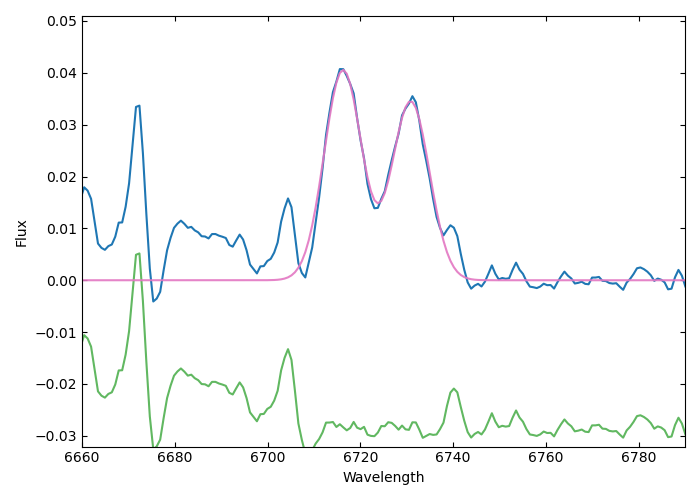

[]


[array([6.00538185e-04, 8.81228763e+00, 4.11854567e-01, 8.81445864e+00,
        3.51228054e-01]),
 array([9.31535899e-06, 1.21898269e-05, 6.48694559e-03, 1.52559279e-05,
        6.20296616e-03])]

In [26]:
line_fit(4, n_fit=1000, maxfev=2000, write=True, broad_component=False)

## 3.3. ${\rm [OII]\lambda\lambda3727,3729}$

100%|██████████| 1000/1000 [00:00<00:00, 1009.02it/s]

----- Narrow components -----
OII3727 mean: 3726.894 +/- 0.158 Angstrom
OII3727 sigma: 243.64 +/- 11.232 km/s
OII3727 sigma: 3.029 +/- 0.140 Angstrom
OII3727 R: 679.45 +/- 34.71
OII3727 flux: 6.58e-01 +/- 2.75e-02
OII3727 reduced chi-square: 0.25




<IPython.core.display.Javascript object>


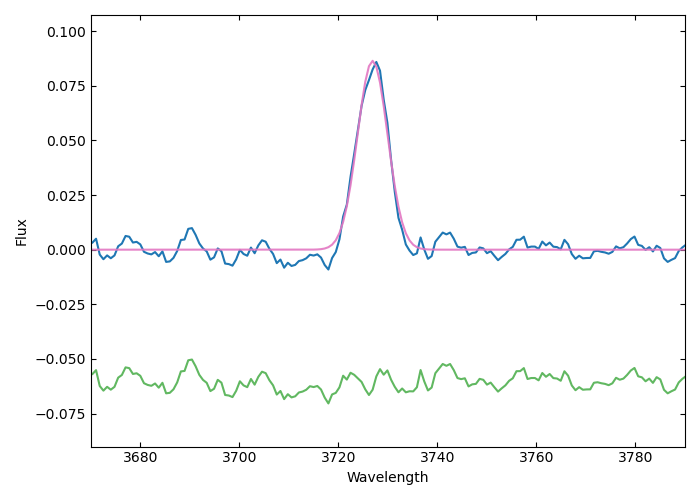

[]


[array([8.12713154e-04, 8.22333036e+00, 6.57750102e-01]),
 array([3.74674033e-05, 4.23424426e-05, 2.74821366e-02])]

In [27]:
line_fit(0, n_fit=1000, maxfev=2000, write=True, broad_component=False)

## 3.4. ${\rm H\beta}$

100%|██████████| 100/100 [00:00<00:00, 166.28it/s]

----- Narrow components -----
Hbeta mean: 4861.270 +/- 0.071 Angstrom
Hbeta sigma: 382.86 +/- 7.944 km/s
Hbeta sigma: 6.208 +/- 0.129 Angstrom
Hbeta R: 887.62 +/- 38.37
Hbeta flux: 1.80e+00 +/- 6.80e-02
Hbeta reduced chi-square: 0.98


----- Broad components -----
Broad1_1 mean: 4860.570 +/- 0.377 Angstrom
Broad1_1 sigma: 1330.50 +/- 44.899 km/s
Broad1_1 sigma: 21.572 +/- 0.728 Angstrom
Broad1_1 R: 887.49 +/- 38.36
Broad1_1 flux: 3.01e+00 +/- 6.56e-02
Broad1_1 reduced chi-square: 0.98




<IPython.core.display.Javascript object>


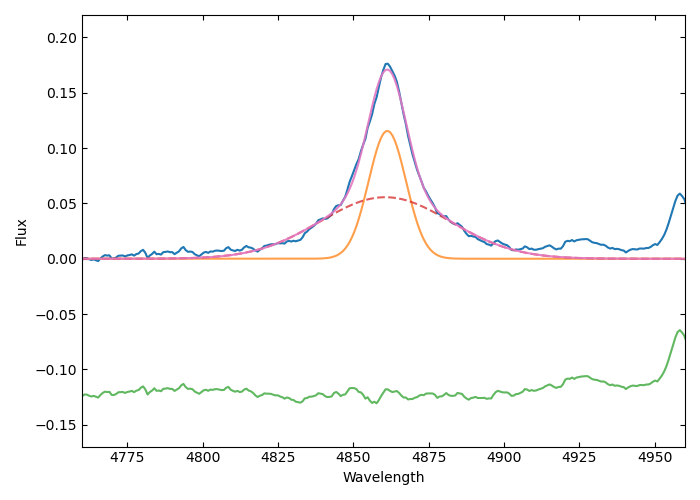

[8.488910962704525, 0.004438088797395071, 3.0053566169145554]


[array([1.27709781e-03, 8.48905500e+00, 1.79786580e+00, 8.48891096e+00,
        4.43808880e-03, 3.00535662e+00]),
 array([2.64994206e-05, 1.46814929e-05, 6.79661363e-02, 7.76252713e-05,
        1.49765664e-04, 6.55712655e-02])]

In [28]:
line_fit(1, n_fit=100, maxfev=2000, write=True, broad_component=True)

100%|██████████| 100/100 [00:00<00:00, 885.50it/s]

----- Narrow components -----
FeII_4923 mean: 4924.372 +/- 2.276 Angstrom
FeII_4923 sigma: 678.09 +/- 133.225 km/s
FeII_4923 sigma: 11.138 +/- 2.188 Angstrom
FeII_4923 R: 899.20 +/- 38.59
FeII_4923 flux: 4.78e-01 +/- 1.08e-01
FeII_4923 reduced chi-square: 0.11




<IPython.core.display.Javascript object>


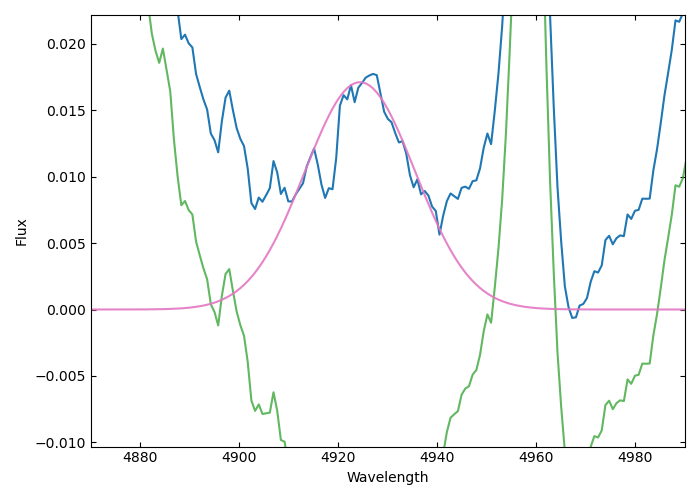

[]


In [29]:
nl, nb = 1, 0
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['FeII_4923'],
           'line_wav':[4927.0],
           'line_sigma':[5.0], 'wav_fit':[4920.0, 4940.0],
           'line_model':lm, 'mask_range':[[4820., 4885.]]}

f1, e_f1 = line_fit(1, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, xtot=wav_res, ytot=fit_spectrum, e2_ytot=fit_variance, **kw_lpar)

100%|██████████| 100/100 [00:00<00:00, 690.54it/s]

----- Narrow components -----
Broad1_1 mean: 4861.091 +/- 0.650 Angstrom
Broad1_1 sigma: 1164.66 +/- 44.028 km/s
Broad1_1 sigma: 18.885 +/- 0.714 Angstrom
Broad1_1 R: 887.58 +/- 38.37
Broad1_1 flux: 3.10e+00 +/- 1.00e-01
Broad1_1 reduced chi-square: 0.85




<IPython.core.display.Javascript object>


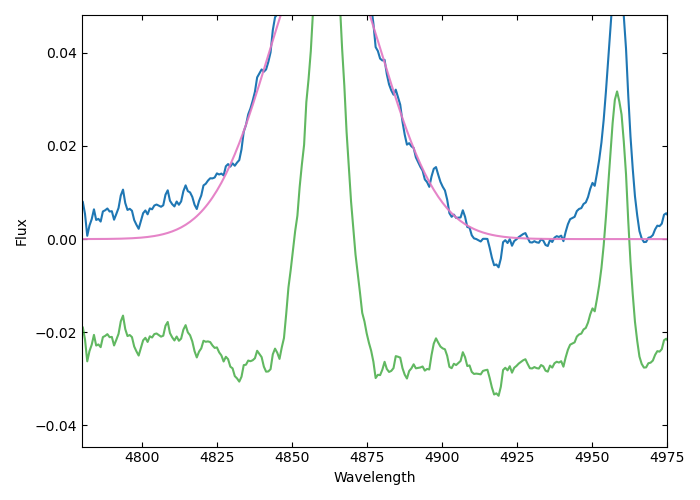

[]


In [30]:
ysub = fit_spectrum - gauss_cdf_scale(wav_res, np.exp(f1[1]), f1[0]*np.exp(f1[1]), f1[2])

nl, nb = 1, 0
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['Broad1_1'],
           'line_wav':[4862.68],
           'line_sigma':[30.0], 'wav_fit':[4830.0, 4925.0],
           'line_model':lm, 'mask_range':[[4840., 4880.]]}

t1, e_t1 = line_fit(1, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=True, xtot=wav_res, ytot=ysub, e2_ytot=fit_variance, **kw_lpar)

100%|██████████| 100/100 [00:00<00:00, 575.08it/s]

----- Narrow components -----
Fe2? mean: 4800.261 +/- 3.975 Angstrom
Fe2? sigma: 1134.82 +/- 226.561 km/s
Fe2? sigma: 18.171 +/- 3.628 Angstrom
Fe2? R: 876.42 +/- 38.16
Fe2? flux: 3.11e-01 +/- 5.45e-02
Fe2? reduced chi-square: 0.31




<IPython.core.display.Javascript object>


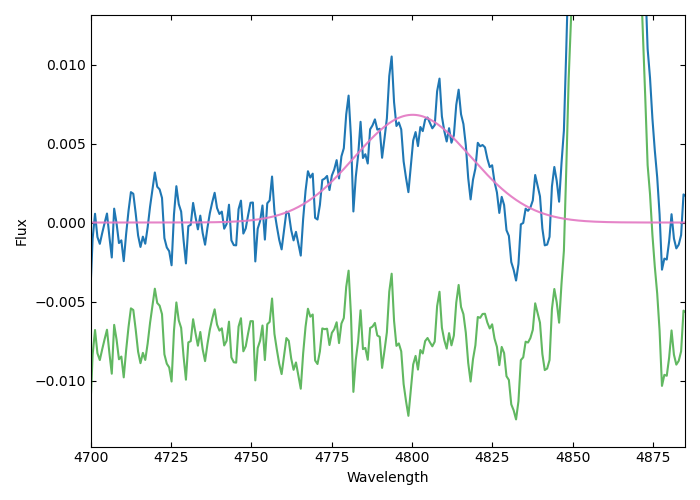

[]


In [31]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[1]), f1[0]*np.exp(f1[1]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(t1[1]), t1[0]*np.exp(t1[1]), t1[2]))

nl, nb = 1, 0
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['Fe2?'],
           'line_wav':[4800.0],
           'line_sigma':[15.0], 'wav_fit':[4750.0, 4835.0],
           'line_model':lm, 'mask_range':[[4840., 4880.]]}

f2, e_f2 = line_fit(1, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=True, xtot=wav_res, ytot=ysub, e2_ytot=fit_variance, **kw_lpar)

100%|██████████| 100/100 [00:00<00:00, 127.66it/s]

----- Narrow components -----
Hbeta mean: 4862.760 +/- 1.057 Angstrom
Hbeta sigma: 206.31 +/- 40.514 km/s
Hbeta sigma: 3.346 +/- 0.657 Angstrom
Hbeta R: 887.89 +/- 38.37
Hbeta flux: 2.33e-01 +/- 2.07e-01
Hbeta reduced chi-square: 0.48


----- Broad components -----
Broad1_1 mean: 4860.643 +/- 1.057 Angstrom
Broad1_1 sigma: 387.70 +/- 26.766 km/s
Broad1_1 sigma: 6.286 +/- 0.434 Angstrom
Broad1_1 R: 887.50 +/- 38.36
Broad1_1 flux: 1.34e+00 +/- 2.09e-01
Broad1_1 reduced chi-square: 0.48




<IPython.core.display.Javascript object>


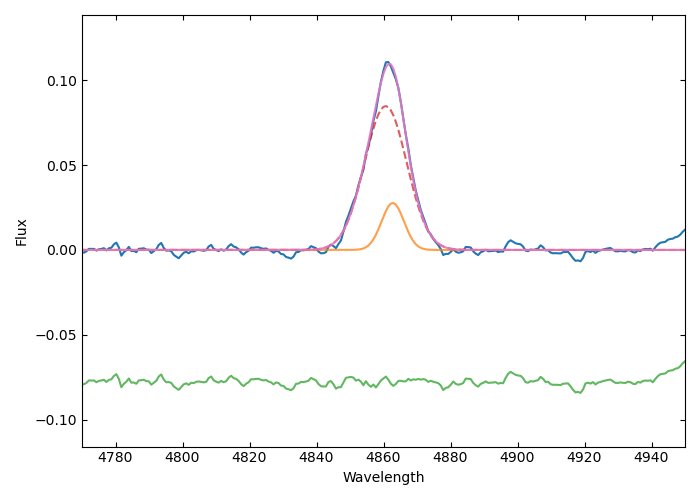

[8.488926076077846, 0.001293226533796806, 1.3352166644635781]


In [32]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[1]), f1[0]*np.exp(f1[1]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(t1[1]), t1[0]*np.exp(t1[1]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(f2[1]), f2[0]*np.exp(f2[1]), f2[2]))

nl, nb = 2, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['Hbeta', 'Broad1_1'],
           'line_wav':[4862.68, 4862.68],
           'line_sigma':[3.0, 6.0], 'wav_fit':[4820.0, 4900.0],
           'line_model':lm, 'mask_range':[[4855., 4870.]]}

t2, e_t2 = line_fit(1, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, xtot=wav_res, ytot=ysub, e2_ytot=fit_variance, **kw_lpar)

In [33]:
# nl, nb = 2, 1
# lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
# kw_lpar = {'nlines':nl, 'nbroad':nb,
#            'line_names':['Hbeta', 'Broad1_1'],
#            'line_wav':[4862.68, 4862.68],
#            'line_sigma':[4.0, 30.0], 'wav_fit':[4800.0, 4900.0],
#            'line_model':lm, 'mask_range':[[4855., 4870.]]}

# t1, e_t1 = line_fit(1, n_fit=100, maxfev=2000, write=False, broad_component=True,
#                     mode='manual', mask=True, xtot=wav_res, ytot=fit_spectrum, e2_ytot=fit_variance, **kw_lpar)

In [34]:
# t1_b = t1[2*(nl-nb)+1:]
# ysub = fit_spectrum - gauss_cdf_scale(wav_res, np.exp(t1_b[0]), t1_b[1]*np.exp(t1_b[0]), t1_b[2])

# nl, nb = 2, 1
# lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
# kw_lpar = {'nlines':nl, 'nbroad':nb,
#            'line_names':['Hbeta', 'Broad1_1'],
#            'line_wav':[4862.68, 4862.68],
#            'line_sigma':[4.0, 10.0], 'wav_fit':[4840.0, 4880.0],
#            'line_model':lm}

# t2, e_t2 = line_fit(1, n_fit=100, maxfev=2000, write=False, broad_component=True,
#                     mode='manual', mask=False, ytot=ysub, **kw_lpar)

In [35]:
# # Combing all the components
# npar = t2[:3]
# bpar = [t1_b, t2[3:]]
# cpar = list(npar) + list(bpar[0]) + list(bpar[1])

# lp = line_par(1, broad_component=True)
# nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = lp
# lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=3, n_broad=2)

# spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
#            np.abs(wav_res-wav_fit[1]).argmin()]
# x_bin = wav_res[1] - wav_res[0]
# x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]    
# y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
# y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
# y_mod = lm(np.log(wav_res), *cpar) / wav_res

# # Figure
# fig, ax = plt.subplots(figsize=(7,5))
# ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
# ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
# ax.set_xlabel('Wavelength')
# ax.set_ylabel('Flux')
# ax.plot(wav_res, fit_spectrum, color='C0')
# for i in np.arange(len(bpar)):
#     y_plt = gauss_cdf_scale(np.log(wav_res), *bpar[i]) / wav_res
#     ax.plot(wav_res, y_plt, color='C3', linestyle='--', alpha=0.75)
# ax.plot(wav_res, multin_gauss_cdf_scale(np.log(wav_res), *npar, n=1, n_broad=0) / wav_res,
#         color='C1', linestyle='-', alpha=0.75)
# ax.plot(wav_res, fit_spectrum - y_mod - 0.7*np.abs(np.max(y_loc)), color='C2', alpha=0.75)
# ax.plot(wav_res, y_mod, color='C6', alpha=0.9)
# plt.tight_layout()
# plt.savefig("fit0_line01.png", dpi=300)

# chisq = ((x_wav*y_loc - lm(np.log(x_wav), *cpar)) / (x_wav*np.sqrt(y_var)))**2.
# dof = len(y_loc) - len(cpar)
# rchisq = np.sum(chisq) / dof
# print(f"Total reduced chi-square: {rchisq:.2f}")

<IPython.core.display.Javascript object>


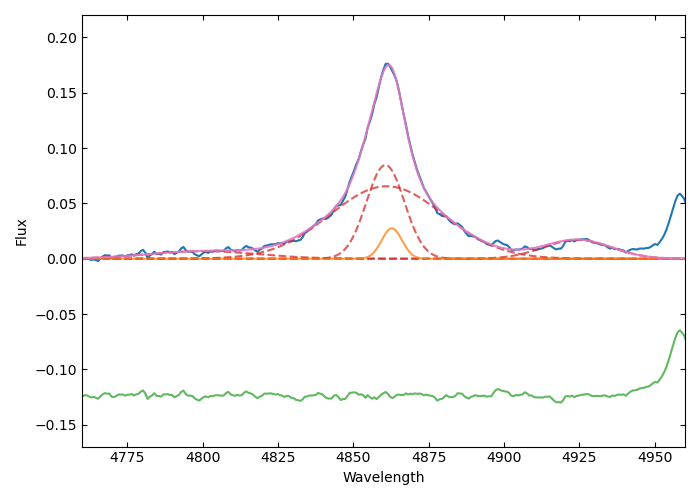

Total reduced chi-square: 0.47


In [36]:
# Combing all the components
npar = t2[:3]
bpar = [[f1[1], f1[0], f1[2]], [f2[1], f2[0], f2[2]], [t1[1], t1[0], t1[2]], t2[3:]]
cpar = list(npar) + list(bpar[0]) + list(bpar[1]) + list(bpar[2]) + list(bpar[3])

lp = line_par(1, broad_component=True)
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = lp
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=5, n_broad=4)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]    
y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
y_mod = lm(np.log(wav_res), *cpar) / wav_res

# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum, color='C0')
for i in np.arange(len(bpar)):
    y_plt = gauss_cdf_scale(np.log(wav_res), *bpar[i]) / wav_res
    ax.plot(wav_res, y_plt, color='C3', linestyle='--', alpha=0.75)
ax.plot(wav_res, multin_gauss_cdf_scale(np.log(wav_res), *npar, n=1, n_broad=0) / wav_res,
        color='C1', linestyle='-', alpha=0.75)
ax.plot(wav_res, fit_spectrum - y_mod - 0.7*np.abs(np.max(y_loc)), color='C2', alpha=0.75)
ax.plot(wav_res, y_mod, color='C6', alpha=0.9)
plt.tight_layout()
plt.savefig("fit0_line01.png", dpi=300)

chisq = ((x_wav*y_loc - lm(np.log(x_wav), *cpar)) / (x_wav*np.sqrt(y_var)))**2.
dof = len(y_loc) - len(cpar)
rchisq = np.sum(chisq) / dof
print(f"Total reduced chi-square: {rchisq:.2f}")

## 3.5. ${\rm [OIII]\lambda\lambda4959,5007}$

100%|██████████| 100/100 [00:01<00:00, 97.88it/s]


----- Narrow components -----
OIII4959 mean: 4958.104 +/- 0.066 Angstrom
OIII4959 sigma: 186.21 +/- 1.718 km/s
OIII4959 sigma: 3.080 +/- 0.028 Angstrom
OIII4959 R: 905.39 +/- 38.70
OIII4959 flux: 4.68e-01 +/- 7.27e-03
OIII4959 reduced chi-square: 4.08


OIII5007 mean: 5006.198 +/- 0.030 Angstrom
OIII5007 sigma: 186.21 +/- 1.718 km/s
OIII5007 sigma: 3.109 +/- 0.029 Angstrom
OIII5007 R: 914.21 +/- 38.87
OIII5007 flux: 1.28e+00 +/- 1.55e-02
OIII5007 reduced chi-square: 4.08


----- Broad components -----
Broad2_1 mean: 5003.555 +/- 0.224 Angstrom
Broad2_1 sigma: 872.67 +/- 20.426 km/s
Broad2_1 sigma: 14.565 +/- 0.341 Angstrom
Broad2_1 R: 913.73 +/- 38.86
Broad2_1 flux: 1.38e+00 +/- 2.06e-02
Broad2_1 reduced chi-square: 4.08




<IPython.core.display.Javascript object>


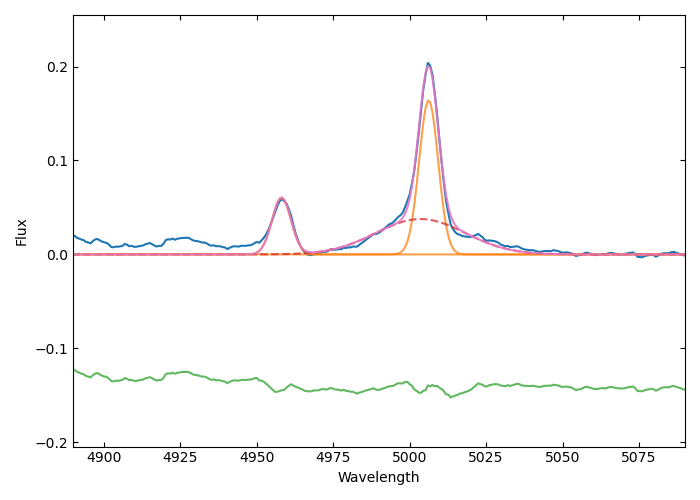

[8.517903902287333, 0.002910919288645801, 1.3760817597076271]


[array([6.21128303e-04, 8.50877862e+00, 4.68225903e-01, 8.51843204e+00,
        1.28302343e+00, 8.51790390e+00, 2.91091929e-03, 1.37608176e+00]),
 array([5.73143841e-06, 1.32406781e-05, 7.26588486e-03, 5.96476308e-06,
        1.55382578e-02, 4.46866795e-05, 6.81346566e-05, 2.06174584e-02])]

In [37]:
line_fit(2, n_fit=100, maxfev=2000, write=True, broad_component=True)

100%|██████████| 100/100 [00:00<00:00, 210.98it/s]

----- Narrow components -----
OIII4959 mean: 4958.043 +/- 0.071 Angstrom
OIII4959 sigma: 211.15 +/- 5.324 km/s
OIII4959 sigma: 3.492 +/- 0.088 Angstrom
OIII4959 R: 905.37 +/- 38.70
OIII4959 flux: 4.97e-01 +/- 1.05e-02
OIII4959 reduced chi-square: 1.30


----- Broad components -----
Broad2_1 mean: 5008.658 +/- 0.972 Angstrom
Broad2_1 sigma: 1041.67 +/- 66.325 km/s
Broad2_1 sigma: 17.403 +/- 1.108 Angstrom
Broad2_1 R: 914.66 +/- 38.88
Broad2_1 flux: 1.06e+00 +/- 1.35e-01
Broad2_1 reduced chi-square: 1.30




<IPython.core.display.Javascript object>


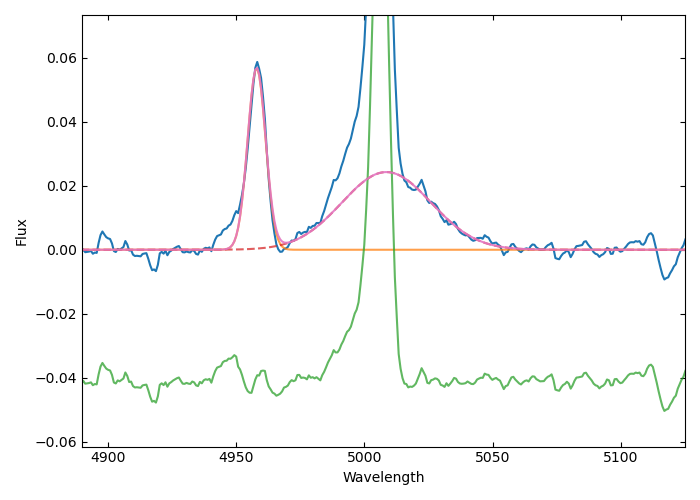

[8.518923325178816, 0.0034746370503363428, 1.0581257816971956]


In [39]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[1]), f1[0]*np.exp(f1[1]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(f2[1]), f2[0]*np.exp(f2[1]), f2[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t1[1]), t1[0]*np.exp(t1[1]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t2[3]), t2[4]*np.exp(t2[3]), t2[5]))

nl, nb = 2, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['OIII4959', 'Broad2_1'],
           'line_wav':[4960.295, 5008.240],
           'line_sigma':[4.0, 15.0], 'wav_fit':[4940.0, 5075.0],
           'line_model':lm, 'mask_range':[[4979., 5027.]]}

r1, e_r1 = line_fit(2, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=True, xtot=wav_res, ytot=ysub, e2_ytot=fit_variance, **kw_lpar)
r1_b = r1[2*(nl-nb)+1:]

100%|██████████| 100/100 [00:01<00:00, 64.28it/s]

----- Narrow components -----
OIII4959 mean: 4958.094 +/- 0.078 Angstrom
OIII4959 sigma: 195.66 +/- 2.617 km/s
OIII4959 sigma: 3.236 +/- 0.043 Angstrom
OIII4959 R: 905.38 +/- 38.70
OIII4959 flux: 4.79e-01 +/- 8.23e-03
OIII4959 reduced chi-square: 1.17


OIII5007 mean: 5005.795 +/- 0.078 Angstrom
OIII5007 sigma: 195.66 +/- 2.617 km/s
OIII5007 sigma: 3.267 +/- 0.044 Angstrom
OIII5007 R: 914.14 +/- 38.87
OIII5007 flux: 1.61e+00 +/- 6.44e-02
OIII5007 reduced chi-square: 1.17


----- Broad components -----
Broad2_2 mean: 4995.089 +/- 0.596 Angstrom
Broad2_2 sigma: 349.90 +/- 24.445 km/s
Broad2_2 sigma: 5.830 +/- 0.407 Angstrom
Broad2_2 R: 912.17 +/- 38.83
Broad2_2 flux: 2.37e-01 +/- 1.82e-02
Broad2_2 reduced chi-square: 1.17




<IPython.core.display.Javascript object>


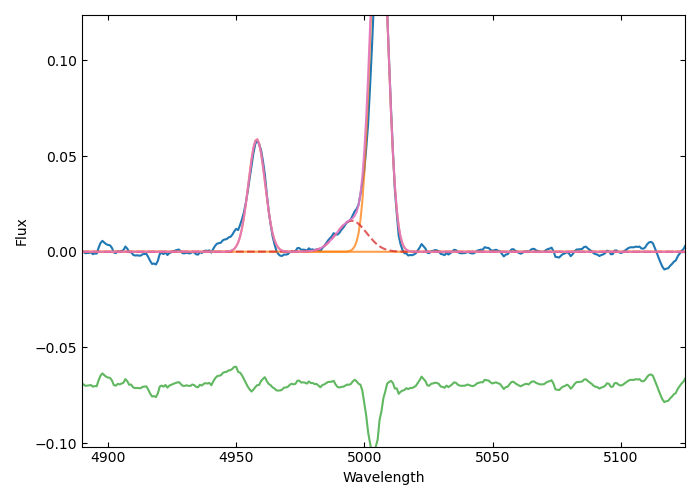

[8.516210418677556, 0.0011671389931827106, 0.23684331693603866]


In [40]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[1]), f1[0]*np.exp(f1[1]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(f2[1]), f2[0]*np.exp(f2[1]), f2[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t1[1]), t1[0]*np.exp(t1[1]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t2[3]), t2[4]*np.exp(t2[3]), t2[5]) +
                       gauss_cdf_scale(wav_res, np.exp(r1_b[0]), r1_b[1]*np.exp(r1_b[0]), r1_b[2]))
                       
nl, nb = 3, 1
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['OIII4959', 'OIII5007', 'Broad2_2', 'Broad2_3'],
           'line_wav':[4960.295, 5008.240, 4995.0, 4948.0],
           'line_sigma':[3.5, 5.0, 5.0], 'wav_fit':[4940.0, 5075.0],
           'line_model':lm, 'mask_range':[[5000., 5010.]]}

r2, e_r2 = line_fit(2, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=True, ytot=ysub, **kw_lpar)
r2_b = r2[2*(nl-nb)+1:]
r3_b = np.array([np.log(np.exp(r2_b[0])-(5008.240 - 4960.295)), r2_b[1], r2_b[2] / 3.])

100%|██████████| 100/100 [00:00<00:00, 376.47it/s]

----- Narrow components -----
OIII4959 mean: 4958.263 +/- 0.063 Angstrom
OIII4959 sigma: 190.93 +/- 1.506 km/s
OIII4959 sigma: 3.158 +/- 0.025 Angstrom
OIII4959 R: 905.41 +/- 38.71
OIII4959 flux: 4.57e-01 +/- 6.88e-03
OIII4959 reduced chi-square: 1.13


OIII5007 mean: 5006.238 +/- 0.021 Angstrom
OIII5007 sigma: 190.93 +/- 1.506 km/s
OIII5007 sigma: 3.188 +/- 0.025 Angstrom
OIII5007 R: 914.22 +/- 38.87
OIII5007 flux: 1.40e+00 +/- 9.33e-03
OIII5007 reduced chi-square: 1.13




<IPython.core.display.Javascript object>


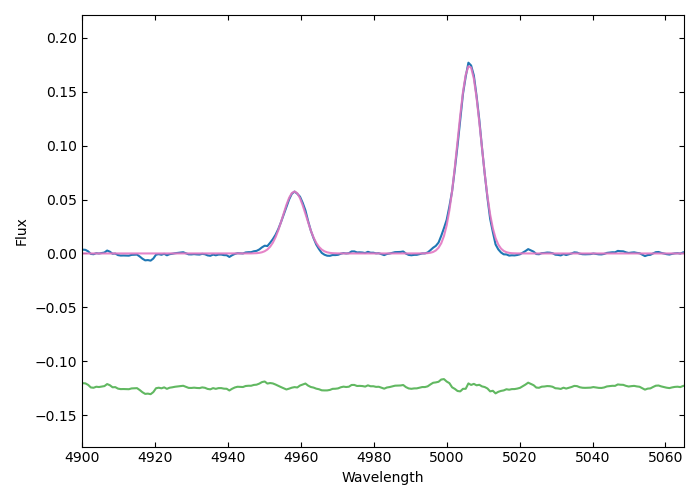

[]


In [43]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[1]), f1[0]*np.exp(f1[1]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(f2[1]), f2[0]*np.exp(f2[1]), f2[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t1[1]), t1[0]*np.exp(t1[1]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t2[3]), t2[4]*np.exp(t2[3]), t2[5]) +
                       gauss_cdf_scale(wav_res, np.exp(r1_b[0]), r1_b[1]*np.exp(r1_b[0]), r1_b[2]) +
                       gauss_cdf_scale(wav_res, np.exp(r2_b[0]), r2_b[1]*np.exp(r2_b[0]), r2_b[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(r3_b[0]), r3_b[1]*np.exp(r3_b[0]), r3_b[2]))

nl, nb = 2, 0
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['OIII4959', 'OIII5007'],
           'line_wav':[4960.295, 5008.240],
           'line_sigma':[3.5], 'wav_fit':[4950.0, 5015.0],
           'line_model':lm, 'mask_range':[[5000., 5012.]]}

r3, e_r3 = line_fit(2, n_fit=100, maxfev=2000, write=False, broad_component=True,
                    mode='manual', mask=False, ytot=ysub, **kw_lpar)

<IPython.core.display.Javascript object>


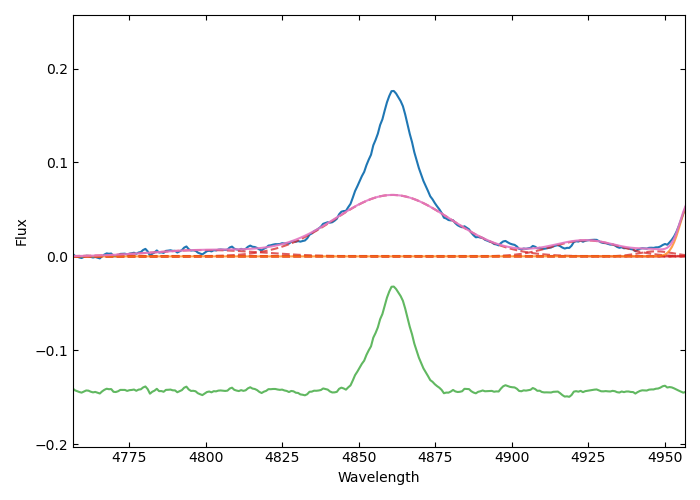

Total reduced chi-square: 1.06


In [44]:
# Combing all the components
npar = r3
bpar = [r1_b, r2_b, r3_b, f1[np.array([1,0,2])], t1[np.array([1,0,2])], f2[np.array([1,0,2])]]
cpar = list(npar) + list(bpar[0]) + list(bpar[1]) + list(bpar[2]) + \
       list(bpar[3]) + list(bpar[4]) + list(bpar[5])

lp = line_par(2, broad_component=True)
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = lp
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=8, n_broad=6)

spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]    
y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
y_mod = lm(np.log(wav_res), *cpar) / wav_res

# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum, color='C0')
for i in np.arange(len(bpar)):
    y_plt = gauss_cdf_scale(np.log(wav_res), *bpar[i]) / wav_res
    ax.plot(wav_res, y_plt, color='C3', linestyle='--', alpha=0.75)
ax.plot(wav_res, multin_gauss_cdf_scale(np.log(wav_res), *npar, n=2, n_broad=0) / wav_res,
        color='C1', linestyle='-', alpha=0.75)
ax.plot(wav_res, fit_spectrum - y_mod - 0.7*np.abs(np.max(y_loc)), color='C2', alpha=0.75)
ax.plot(wav_res, y_mod, color='C6', alpha=0.9)
plt.tight_layout()
plt.savefig("fit0_line02.png", dpi=300)

chisq = ((x_wav*y_loc - lm(np.log(x_wav), *cpar)) / (x_wav*np.sqrt(y_var)))**2.
dof = len(y_loc) - len(cpar)
rchisq = np.sum(chisq) / dof
print(f"Total reduced chi-square: {rchisq:.2f}")

## 3.6. ${\rm H\beta}+{\rm [OIII]\lambda\lambda4959,5007}$

100%|██████████| 1000/1000 [00:07<00:00, 138.61it/s]

----- Narrow components -----
Hbeta mean: 4862.850 +/- 0.194 Angstrom
Hbeta sigma: 191.47 +/- 1.399 km/s
Hbeta sigma: 3.106 +/- 0.023 Angstrom
Hbeta R: 887.91 +/- 38.37
Hbeta flux: 2.22e-01 +/- 8.70e-03
Hbeta reduced chi-square: 0.70


OIII4959 mean: 4958.265 +/- 0.070 Angstrom
OIII4959 sigma: 191.47 +/- 1.399 km/s
OIII4959 sigma: 3.167 +/- 0.023 Angstrom
OIII4959 R: 905.41 +/- 38.71
OIII4959 flux: 4.60e-01 +/- 7.10e-03
OIII4959 reduced chi-square: 0.70


OIII5007 mean: 5006.235 +/- 0.024 Angstrom
OIII5007 sigma: 191.47 +/- 1.399 km/s
OIII5007 sigma: 3.197 +/- 0.023 Angstrom
OIII5007 R: 914.22 +/- 38.87
OIII5007 flux: 1.40e+00 +/- 9.03e-03
OIII5007 reduced chi-square: 0.70




<IPython.core.display.Javascript object>


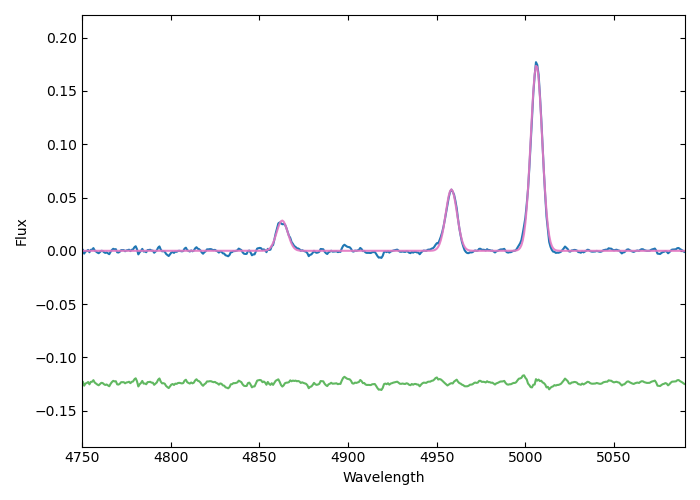

[]


In [46]:
ysub = fit_spectrum - (gauss_cdf_scale(wav_res, np.exp(f1[1]), f1[0]*np.exp(f1[1]), f1[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(f2[1]), f2[0]*np.exp(f2[1]), f2[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t1[1]), t1[0]*np.exp(t1[1]), t1[2]) +
                       gauss_cdf_scale(wav_res, np.exp(t2[3]), t2[4]*np.exp(t2[3]), t2[5]) +
                       gauss_cdf_scale(wav_res, np.exp(r1_b[0]), r1_b[1]*np.exp(r1_b[0]), r1_b[2]) +
                       gauss_cdf_scale(wav_res, np.exp(r2_b[0]), r2_b[1]*np.exp(r2_b[0]), r2_b[2]) + 
                       gauss_cdf_scale(wav_res, np.exp(r3_b[0]), r3_b[1]*np.exp(r3_b[0]), r3_b[2]))

nl, nb = 3, 0
lm = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nl, n_broad=nb)
kw_lpar = {'nlines':nl, 'nbroad':nb,
           'line_names':['Hbeta', 'OIII4959', 'OIII5007'],
           'line_wav':[4862.68, 4960.295, 5008.240],
           'line_sigma':[3.0], 'wav_fit':[4800.0, 5040.0],
           'line_model':lm, 'mask_range':[[5000., 5012.]]}

ho, e_ho = line_fit(2, n_fit=1000, maxfev=2000, write=False, broad_component=False,
                    mode='manual', mask=False, ytot=ysub, **kw_lpar)

In [2]:
t2

NameError: name 't2' is not defined

# 4. Additional Tasks for Broad Components

## 4.1. Creating a New Image with Gaussian Profile

In [241]:
from astropy.modeling.models import Gaussian2D
fwhm = 1.0    # arcsec
pixel_scale = 0.1    # arcsec/pix
x_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
y_sigma = (fwhm/pixel_scale) / (2.0*np.sqrt(2.0*np.log(2.0)))
print(x_sigma, y_sigma)
g2d = Gaussian2D(amplitude = 1, x_mean = yInd, y_mean = xInd, x_stddev = x_sigma, y_stddev = y_sigma)
img_g2d = g2d(*np.mgrid[0:d_sci.shape[1], 0:d_sci.shape[2]])

4.2466090014400955 4.2466090014400955


<IPython.core.display.Javascript object>


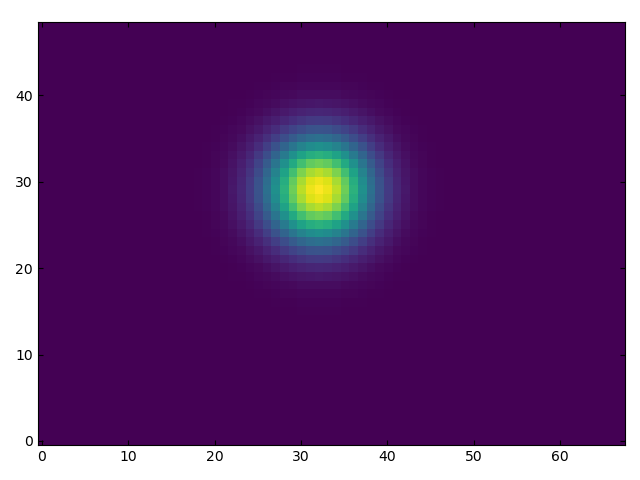

In [242]:
fig, ax = plt.subplots()
ax.imshow(img_g2d, origin = 'lower')
plt.tight_layout()

fits.writeto("g2d.fits", img_g2d, overwrite=True)

## 4.2. Checking for Spectra in an Arbitrary Bin

### 4.2.1. Setting an Arbitrary Bin

In [243]:
nbin = 50    # arbitrary bin

print(f"Bin {nbin:d}")

fit_spectrum = dat[:, nbin]
fit_variance = var[:, nbin]
fit_continuum = cont[:, nbin]

Bin 50


In [244]:
indices = np.argwhere(data_vbin == nbin)
print("The (x,y) indices of the bin")
print(indices)

The (x,y) indices of the bin
[[22 31]]


In [245]:
npix = indices.shape[0]
print(f"Number of pixels in the bin: {npix:d}")

Number of pixels in the bin: 1


### 4.2.2. Creating an Image of Initial Guess for the Broad Component Factors

In [246]:
print("Gaussian factors of this bin:")
img_g2d[indices[:, 0], indices[:, 1]]

Gaussian factors of this bin:


array([0.25])

In [247]:
fac = np.sum(img_g2d[indices[:, 0], indices[:, 1]]) / npix
if (mode == "subcircular"):
    fac /= (np.sum(img_g2d*msk))
print(f"Mean Gaussian factor of broad components: {fac:.4f}")

Mean Gaussian factor of broad components: 0.0062


<IPython.core.display.Javascript object>


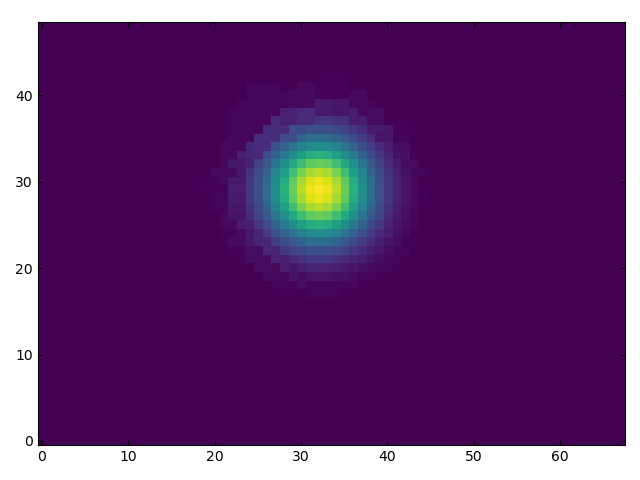

In [248]:
gfac = np.zeros_like(img_g2d)
for b in np.unique(data_vbin):
    binwhere = np.argwhere(data_vbin == b)
    if (b == -99):
        fc = 0.0
    else:
        fc = np.sum(img_g2d[binwhere[:, 0], binwhere[:, 1]])
#         fc = img_g2d[binwhere[:, 0], binwhere[:, 1]].max()
    gfac[data_vbin == b] = fc / binwhere.shape[0]
    
fig, ax = plt.subplots()
ax.imshow(gfac, origin = 'lower', vmin=0.01, vmax=1.0)
plt.tight_layout()
fits.writeto("gfac.fits", gfac, overwrite=True)

### 4.2.3. Plotting the Spectra for Visual Check

<IPython.core.display.Javascript object>


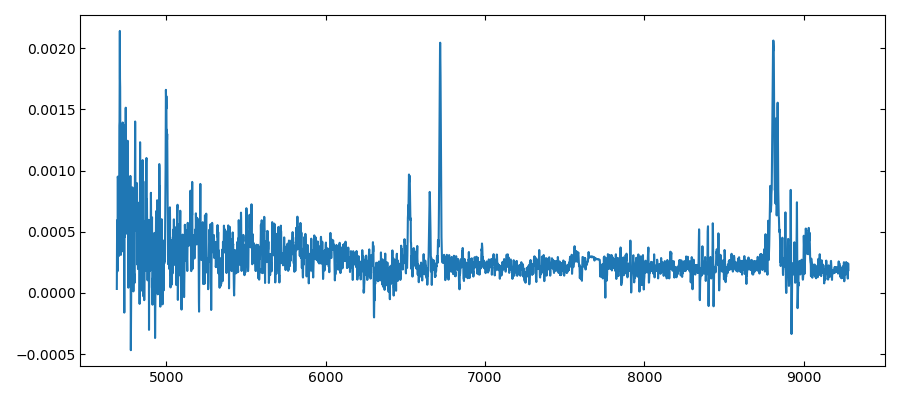

In [249]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

fig, ax = plt.subplots(figsize=(9,4))
# ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
# ax.plot(wav_res, fit_spectrum)
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b1[0], mpar_b1[1], fac*mpar_b1[2]))
# ax.plot(wav_res, gauss_cdf_scale(wav_res, mpar_b2[0], mpar_b2[1], fac*mpar_b2[2]))
ax.plot(wav_obs, binned_spectrum[:, nbin] / indices.shape[0])
plt.tight_layout()

<IPython.core.display.Javascript object>


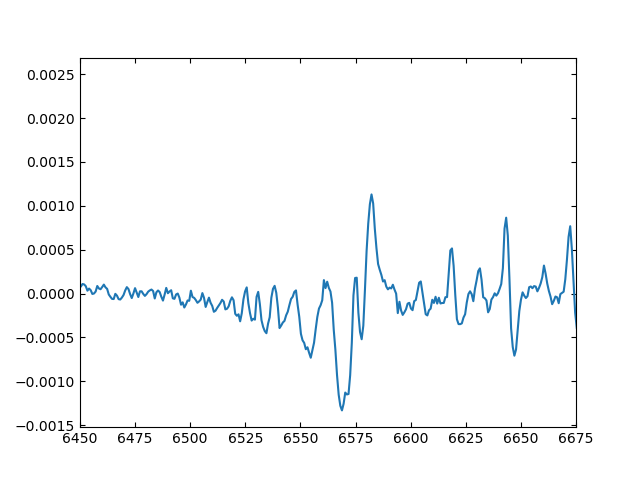

In [250]:
# npar = s3
# bpar = [s1_b, s2_b]
# cpar = list(npar) + list(bpar[0]) + list(bpar[1])

broad_plt = 0
for i in np.arange(2):
    exec(f"mpar_b = s{i+1:d}_b")
# for i in np.arange(nbroad):
#     exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - fac*broad_plt)

In [251]:
# broad_plt = 0
# for i in np.arange(nbroad):
#     exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
#     broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
# fig, ax = plt.subplots()
# ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
# ax.plot(wav_res, fit_spectrum - fac*broad_plt)

### 4.2.4. Line Fitting with Fixing Broad Components

0.006186386890544019 ---> 0.0033489920507409946
0.0001822788059440258
----- Narrow components -----
NII6548 mean: 6547.411 +/- 0.994 Angstrom
NII6548 sigma: 129.35 +/- 9.597 km/s
NII6548 sigma: 2.825 +/- 0.210 Angstrom
NII6548 R: 1197.03 +/- 44.71
NII6548 flux: 2.16e-03 +/- 6.17e-04
NII6548 reduced chi-square: 0.16


Halpha mean: 6561.555 +/- 0.231 Angstrom
Halpha sigma: 129.35 +/- 9.597 km/s
Halpha sigma: 2.831 +/- 0.210 Angstrom
Halpha R: 1199.63 +/- 44.77
Halpha flux: 9.28e-03 +/- 1.08e-03
Halpha reduced chi-square: 0.53


NII6584 mean: 6582.412 +/- 0.238 Angstrom
NII6584 sigma: 129.35 +/- 9.597 km/s
NII6584 sigma: 2.840 +/- 0.211 Angstrom
NII6584 R: 1203.46 +/- 44.85
NII6584 flux: 9.05e-03 +/- 7.33e-04
NII6584 reduced chi-square: 0.91


----- Broad components -----
Broad3_1 mean: 6558.882 +/- 0.000 Angstrom
Broad3_1 sigma: 1732.93 +/- 0.000 km/s
Broad3_1 sigma: 37.913 +/- 0.000 Angstrom
Broad3_1 R: 1199.14 +/- 44.76
Broad3_1 flux: 2.55e-02 +/- 1.39e-03
Broad3_1 reduced chi-square: 

<IPython.core.display.Javascript object>


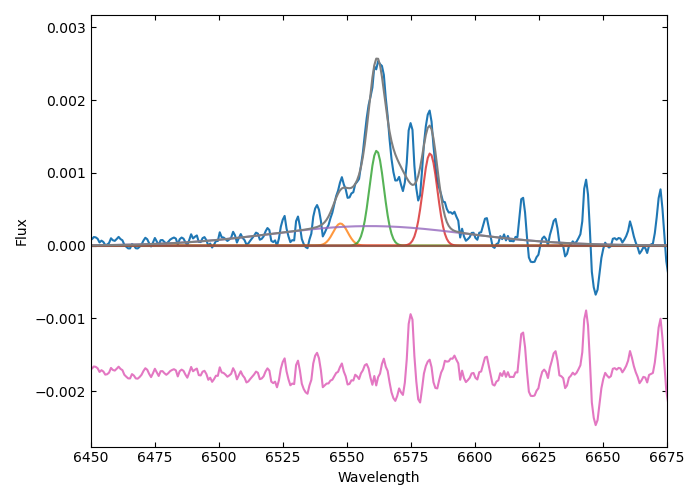

In [257]:
# Line fitting: Monte Carlo simulation of curve_fit (H alpha)
line_numbers = 3
# nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers)#, broad_component=True)
nlines, nbroad = 5, 2
line_names = ['NII6548', 'Halpha', 'NII6584', 'Broad3_1', 'Broad3_2']
line_wav = [6549.86, 6564.61, 6585.27, 6564.61, 6564.61]
line_sigma = [3.0, 10.0, 30.0]
wav_fit = [6500.0, 6625.0]
line_model = lambda x, *pars: multin_gauss_cdf_scale(x, *pars, n=nlines, n_broad=nbroad)


spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
           np.abs(wav_res-wav_fit[1]).argmin()]
x_bin = wav_res[1] - wav_res[0]
x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
x_fit = np.log(x_wav)

y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
ind_fac = 10
y_dat = y_loc / ind_fac# / indices.shape[0]
flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
y_fit = x_wav * y_dat

# broad_fit = 0
# for i in np.arange(nbroad):
#     exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
#     broad_fit += gauss_cdf_scale(x_fit, *mpar_b)

broad_fit = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = s{i+1:d}_b")
    broad_fit += gauss_cdf_scale(x_fit, *mpar_b)
    
# Model fitting
def line_model2(x, *pars):
    narrow_comp = 0
    for i in np.arange(nlines-nbroad):
        narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
    broad_comp = pars[2*(nlines-nbroad)+1] * broad_fit
    return narrow_comp + broad_comp
    
param = [line_sigma[0] / line_wav[0]]
for j in np.arange(nlines-nbroad):
    param += [np.log(line_wav[j]), flx_scale0 / nlines]
param += [fac]

popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
perr = np.sqrt(np.diag(pcov))
mpar, e_mpar = popt, perr


# Arranging parameters
ffac = mpar[-1]
print(fac, "--->", ffac, "--->", ffac*ind_fac)
# mpar[2::2] *= indices.shape[0]
mpar = list(mpar[:2*(nlines-nbroad)+1])
for i in np.arange(nbroad):
    exec(f"mpar_b = s{i+1:d}_b")
#     exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    mpar += [mpar_b[0], mpar_b[1], ffac*mpar_b[2]*ind_fac]#*indices.shape[0]]

e_ffac = e_mpar[-1]
print(e_ffac)
# e_mpar[2::2] *= indices.shape[0]
e_mpar = list(e_mpar[:2*(nlines-nbroad)+1])
for i in np.arange(nbroad):
    exec(f"mpar_b = s{i+1:d}_b")
#     exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    e_mpar += [0.0, 0.0, e_ffac*mpar_b[2]*ind_fac]#*indices.shape[0]]

    
# Printing the results
# f = open('linefit_integrated.txt','a')
for i in np.arange(nlines):
    if (i == 0):
        print("----- Narrow components -----")
    if (i == nlines-nbroad):
        print("----- Broad components -----")
    
    if (i < nlines-nbroad):
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[0], c*e_mpar[0]
        flux, e_flux = mpar[2*i+2], e_mpar[2*i+2]
    else:
        mu, e_mu = np.exp(mpar[2*i+1]), np.exp(mpar[2*i+1])*e_mpar[2*i+1]
        vsig, e_vsig = c*mpar[2*i+2], c*e_mpar[2*i+2]
        flux, e_flux = mpar[2*i+3], e_mpar[2*i+3]        
        
    print(line_names[i]+f" mean: {mu:.3f} +/- {e_mu:.3f} Angstrom")

    print(line_names[i]+f" sigma: {vsig:.2f} +/- {e_vsig:.3f} km/s")
    lsig = mu * vsig / c
    e_lsig = lsig * np.sqrt((e_mu/mu)**2.0 + (e_vsig/vsig)**2.0)
    print(line_names[i]+f" sigma: {lsig:.3f} +/- {e_lsig:.3f} Angstrom")

    specR = par[0]+par[1]*mu*(1+redshift)
    e_specR = np.sqrt(e_par[0]**2.0 + (e_par[1]*mu*(1+redshift))**2.0)
    print(line_names[i]+f" R: {specR:.2f} +/- {e_specR:.2f}")

    print(line_names[i]+f" flux: {flux:.2e} +/- {e_flux:.2e}")

    spx_line = [np.abs(x_fit-(np.log(mu)-3*lsig/mu)).argmin(),
                np.abs(x_fit-(np.log(mu)+3*lsig/mu)).argmin()]
    chisq = ((x_wav*y_loc - line_model(x_fit, *mpar)) / (x_wav*np.sqrt(y_var)))**2.
    dof = len(y_loc[spx_line[0]:spx_line[1]+1])-3#*nlines
    rchisq = np.sum(chisq[spx_line[0]:spx_line[1]+1]) / dof
    print(line_names[i]+f" reduced chi-square: {rchisq:.2f}")
    print("\n")

    
# Figure
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.set_ylim([np.min(y_loc)-1.0*np.abs(np.max(y_loc)), 1.25*np.abs(np.max(y_loc))])
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux')
ax.plot(wav_res, fit_spectrum)
if (nbroad >= 1):
    for i in np.arange(nlines):
        if (i < nlines-nbroad):
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[0]*np.exp(mpar[2*i+1]), mpar[2*i+2])
        else:
            y_plt = gauss_cdf_scale(wav_res, np.exp(mpar[2*i+1]), mpar[2*i+2]*np.exp(mpar[2*i+1]), mpar[2*i+3])
        ax.plot(wav_res, y_plt, alpha=0.8)                
ax.plot(wav_res, fit_spectrum - line_model(np.log(wav_res), *mpar) / wav_res - 0.7*np.abs(np.max(y_loc)))
ax.plot(wav_res, line_model(np.log(wav_res), *mpar) / wav_res)
plt.tight_layout()

### 4.2.5. Check for Broad-Component-Subtracted Spectra

* ${\rm H\alpha+[NII]}\lambda\lambda6548,6584$

<IPython.core.display.Javascript object>


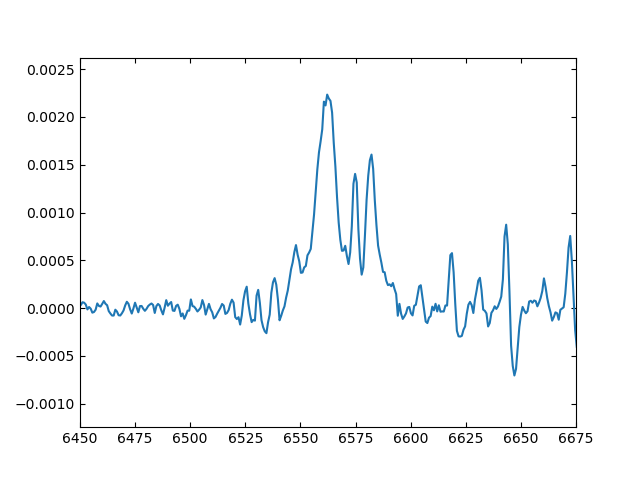

In [33]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*indices.shape[0]*broad_plt)

* ${\rm H\beta}$

<IPython.core.display.Javascript object>


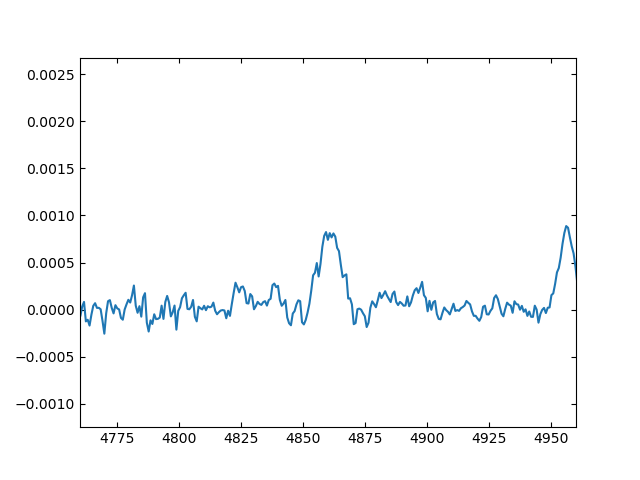

In [34]:
line_numbers = 1
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

broad_plt = 0
for i in np.arange(nbroad):
    exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
    broad_plt += gauss_cdf_scale(wav_res, np.exp(mpar_b[0]), mpar_b[1]*np.exp(mpar_b[0]), mpar_b[2])
    
fig, ax = plt.subplots()
ax.set_xlim([wav_fit[0]-50.0, wav_fit[1]+50.0])
ax.plot(wav_res, fit_spectrum - ffac*indices.shape[0]*broad_plt)

## 4.3. Creating the broad component factor map

In [35]:
line_numbers = 3
nlines, nbroad, line_names, line_wav, line_sigma, wav_fit, line_model = line_par(line_numbers, broad_component=True)

bfac = np.zeros(binned_spectrum.shape[1])
e_bfac = np.zeros(binned_spectrum.shape[1])
nmax_bin = data_vbin[yInd, xInd]
bfac[nmax_bin], e_bfac[nmax_bin] = 1.0, 0.0
print(f"Maximum - Bin {nmax_bin:d} : {bfac[0]:.3f} +/- {e_bfac[0]:.3f}")

for ibin in np.arange(binned_spectrum.shape[1]):
    fit_spectrum = dat[:, ibin]
    fit_variance = var[:, ibin]
    fac = gfac[data_vbin == ibin][0]
    
    if (ibin == nmax_bin):
        pass
    
    if (fac < 0.01):
        bfac[ibin] = 0.
        e_bfac[ibin] = 0.
    
    elif ((ibin != nmax_bin) & (fac >= 0.01)):
        spx_fit = [np.abs(wav_res-wav_fit[0]).argmin(),
                   np.abs(wav_res-wav_fit[1]).argmin()]
        x_bin = wav_res[1] - wav_res[0]
        x_wav = wav_res[spx_fit[0]:spx_fit[1]+1]
        x_fit = np.log(x_wav)

        y_loc = fit_spectrum[spx_fit[0]:spx_fit[1]+1]
        y_var = fit_variance[spx_fit[0]:spx_fit[1]+1]
        y_dat = y_loc / indices.shape[0]
        flx_scale0 = np.sum(np.abs(y_dat)*x_bin)
        y_fit = x_wav * y_dat

        broad_fit = 0
        for i in np.arange(nbroad):
            exec(f"mpar_b = mpar_l{line_numbers:d}_b{i+1:d}")
            broad_fit += gauss_cdf_scale(x_fit, *mpar_b)

        # Model fitting
        def line_model2(x, *pars):
            narrow_comp = 0
            for i in np.arange(nlines-nbroad):
                narrow_comp += gauss_cdf_scale(x, pars[2*i+1], pars[0], pars[2*i+2])
            broad_comp = pars[2*(nlines-nbroad)+1] * broad_fit
            return narrow_comp + broad_comp

        param = [line_sigma[0] / line_wav[0]]
        for j in np.arange(nlines-nbroad):
            param += [np.log(line_wav[j]), flx_scale0 / nlines]
        param += [fac]
        
        try:
            popt, pcov = curve_fit(line_model2, x_fit, y_fit, param)
            perr = np.sqrt(np.diag(pcov))
            
            bfac[ibin] = np.maximum(0.0, popt[-1])*indices.shape[0]
            e_bfac[ibin] = np.maximum(0.0, perr[-1])*indices.shape[0]
        
        except RuntimeError:
            bfac[ibin] = np.maximum(0.0, param[-1])*indices.shape[0]
            e_bfac[ibin] = 0.0
        
        
    print(f"Bin {ibin:d} : {bfac[ibin]:.3f} +/- {e_bfac[ibin]:.3f}")


Maximum - Bin 0 : 1.000 +/- 0.000
Bin 0 : 1.000 +/- 0.000
Bin 1 : 0.852 +/- 0.037
Bin 2 : 0.756 +/- 0.042
Bin 3 : 0.843 +/- 0.034
Bin 4 : 0.696 +/- 0.028
Bin 5 : 0.774 +/- 0.027
Bin 6 : 0.561 +/- 0.030
Bin 7 : 0.497 +/- 0.027
Bin 8 : 0.670 +/- 0.028
Bin 9 : 0.499 +/- 0.026
Bin 10 : 0.412 +/- 0.024
Bin 11 : 0.355 +/- 0.031
Bin 12 : 0.298 +/- 0.028
Bin 13 : 0.550 +/- 0.029
Bin 14 : 0.236 +/- 0.030
Bin 15 : 0.487 +/- 0.024
Bin 16 : 0.260 +/- 0.024
Bin 17 : 0.303 +/- 0.026
Bin 18 : 0.178 +/- 0.030
Bin 19 : 0.249 +/- 0.025
Bin 20 : 0.175 +/- 0.021
Bin 21 : 0.132 +/- 0.026
Bin 22 : 0.322 +/- 0.027
Bin 23 : 0.539 +/- 0.024
Bin 24 : 0.398 +/- 0.023
Bin 25 : 0.608 +/- 0.029
Bin 26 : 0.104 +/- 0.023
Bin 27 : 0.125 +/- 0.021
Bin 28 : 0.083 +/- 0.020
Bin 29 : 0.105 +/- 0.021
Bin 30 : 0.166 +/- 0.022
Bin 31 : 0.268 +/- 0.022
Bin 32 : 0.071 +/- 0.020
Bin 33 : 0.058 +/- 0.019
Bin 34 : 0.085 +/- 0.018
Bin 35 : 0.135 +/- 0.019
Bin 36 : 0.084 +/- 0.020
Bin 37 : 0.093 +/- 0.021
Bin 38 : 0.053 +/- 0.018
B

Bin 324 : 0.611 +/- 0.192
Bin 325 : 0.081 +/- 0.042
Bin 326 : 0.045 +/- 0.020
Bin 327 : 0.172 +/- 0.017
Bin 328 : 0.073 +/- 0.013
Bin 329 : 0.050 +/- 0.022
Bin 330 : 0.121 +/- 0.016
Bin 331 : 0.156 +/- 0.017
Bin 332 : 0.069 +/- 0.025
Bin 333 : 0.098 +/- 0.009
Bin 334 : 0.071 +/- 0.017
Bin 335 : 0.020 +/- 0.010
Bin 336 : 0.000 +/- 0.017
Bin 337 : 0.111 +/- 0.015
Bin 338 : 0.135 +/- 0.016
Bin 339 : 0.212 +/- 0.032
Bin 340 : 0.066 +/- 0.017
Bin 341 : 0.048 +/- 0.011
Bin 342 : 0.114 +/- 0.018
Bin 343 : 0.028 +/- 0.022
Bin 344 : 0.000 +/- 0.000
Bin 345 : 0.091 +/- 0.008
Bin 346 : 0.060 +/- 0.011
Bin 347 : 0.072 +/- 0.015
Bin 348 : 0.096 +/- 0.016
Bin 349 : 0.064 +/- 0.024
Bin 350 : 0.003 +/- 0.016
Bin 351 : 0.084 +/- 0.016
Bin 352 : 0.002 +/- 0.015
Bin 353 : 0.059 +/- 0.025
Bin 354 : 0.071 +/- 0.019
Bin 355 : 0.099 +/- 0.007
Bin 356 : 0.094 +/- 0.016
Bin 357 : 0.000 +/- 0.000
Bin 358 : 0.014 +/- 0.012
Bin 359 : 0.000 +/- 0.000
Bin 360 : 0.091 +/- 0.016
Bin 361 : 0.066 +/- 0.018
Bin 362 : 0.

<IPython.core.display.Javascript object>


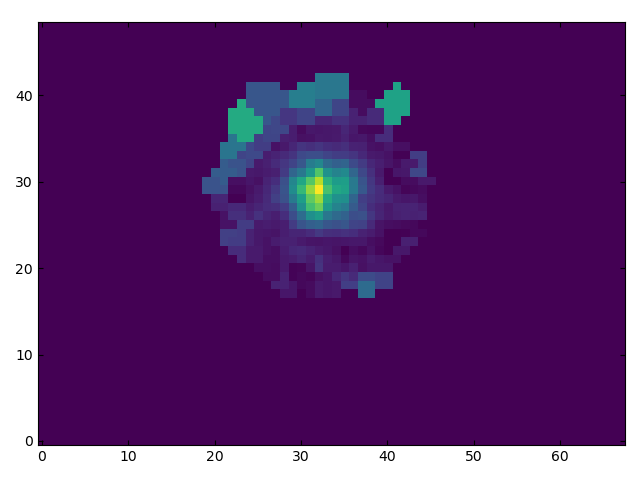

In [36]:
bfac_2D = np.zeros_like(data_vbin).astype('float')
for b in np.unique(data_vbin):
    if (b == -99):
        bf = 0.0
    else:
        bf = bfac[b]
    bfac_2D[data_vbin == b] = bf
        
fig, ax = plt.subplots()
ax.imshow(bfac_2D, origin = 'lower', vmin=0, vmax=1)
plt.tight_layout()
fits.writeto("bfac_2D.fits", bfac_2D, overwrite=True)

<IPython.core.display.Javascript object>


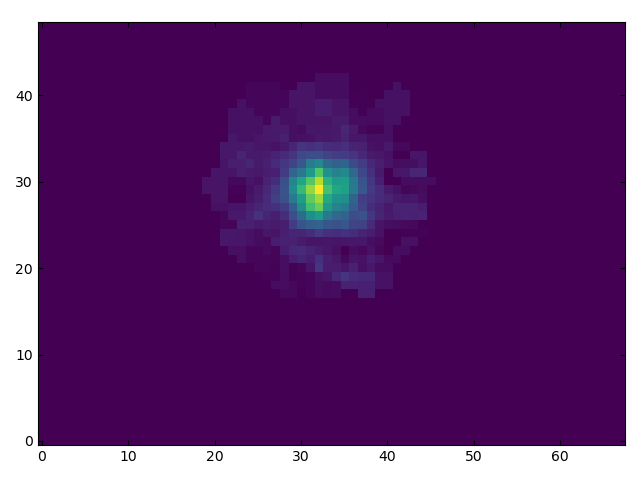

In [37]:
bfac_pix = np.zeros_like(data_vbin).astype('float')
for b in np.unique(data_vbin):
    if (b == -99):
        bf = 0.0
    else:
        bf = bfac[b]
    bfac_pix[data_vbin == b] = bf / np.sum(data_vbin == b)
        
fig, ax = plt.subplots()
ax.imshow(bfac_pix, origin = 'lower', vmin=0, vmax=1)
plt.tight_layout()
fits.writeto("bfac_pix.fits", bfac_pix, overwrite=True)